#  <center> Heat Budget </center> #

The heat budget can written in the familiar form:
\begin{equation}
\frac{\partial T}{\partial t} + \nabla \cdot \textbf{u}T = \frac{\partial Q}{\partial z}
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Qplot = 'Y'
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

\begin{equation}
\frac{\partial \overline{vT}}{\partial y } + \frac{\partial \overline{wT}}{\partial z } +  = \frac{\partial Q}{\partial z}.
\end{equation}

In [3]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVolv = 5000**2*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # and volume weight it       
    VT = (c.mnc('Tav_VT.nc','VVELTH'))*CellVolv 
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    # No slip bottom so W[-1]=0
    npad = ((0, 1), (0, 0), (0, 0))
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)*CellVolw
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    dVT = (VT[:,0:-1,:]-VT[:,1::,:]) # volume weighted heat flux gradient
    dWT = (WT[1::,:,:]-WT[0:-1,:,:]) # volume weighted heat flux gradient
    Div = -((((dVT + dWT)).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Div+Surcor)*10**6,'k',linewidth=3) # Divergence + free surface correction 
    p = plt.plot(c.yc/1000,(Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\frac{\partial  \overline{vT}}{\partial y} + \frac{\partial  \overline{wT}}{\partial z}$',
                'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

NameError: name 'CellVol' is not defined

\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}

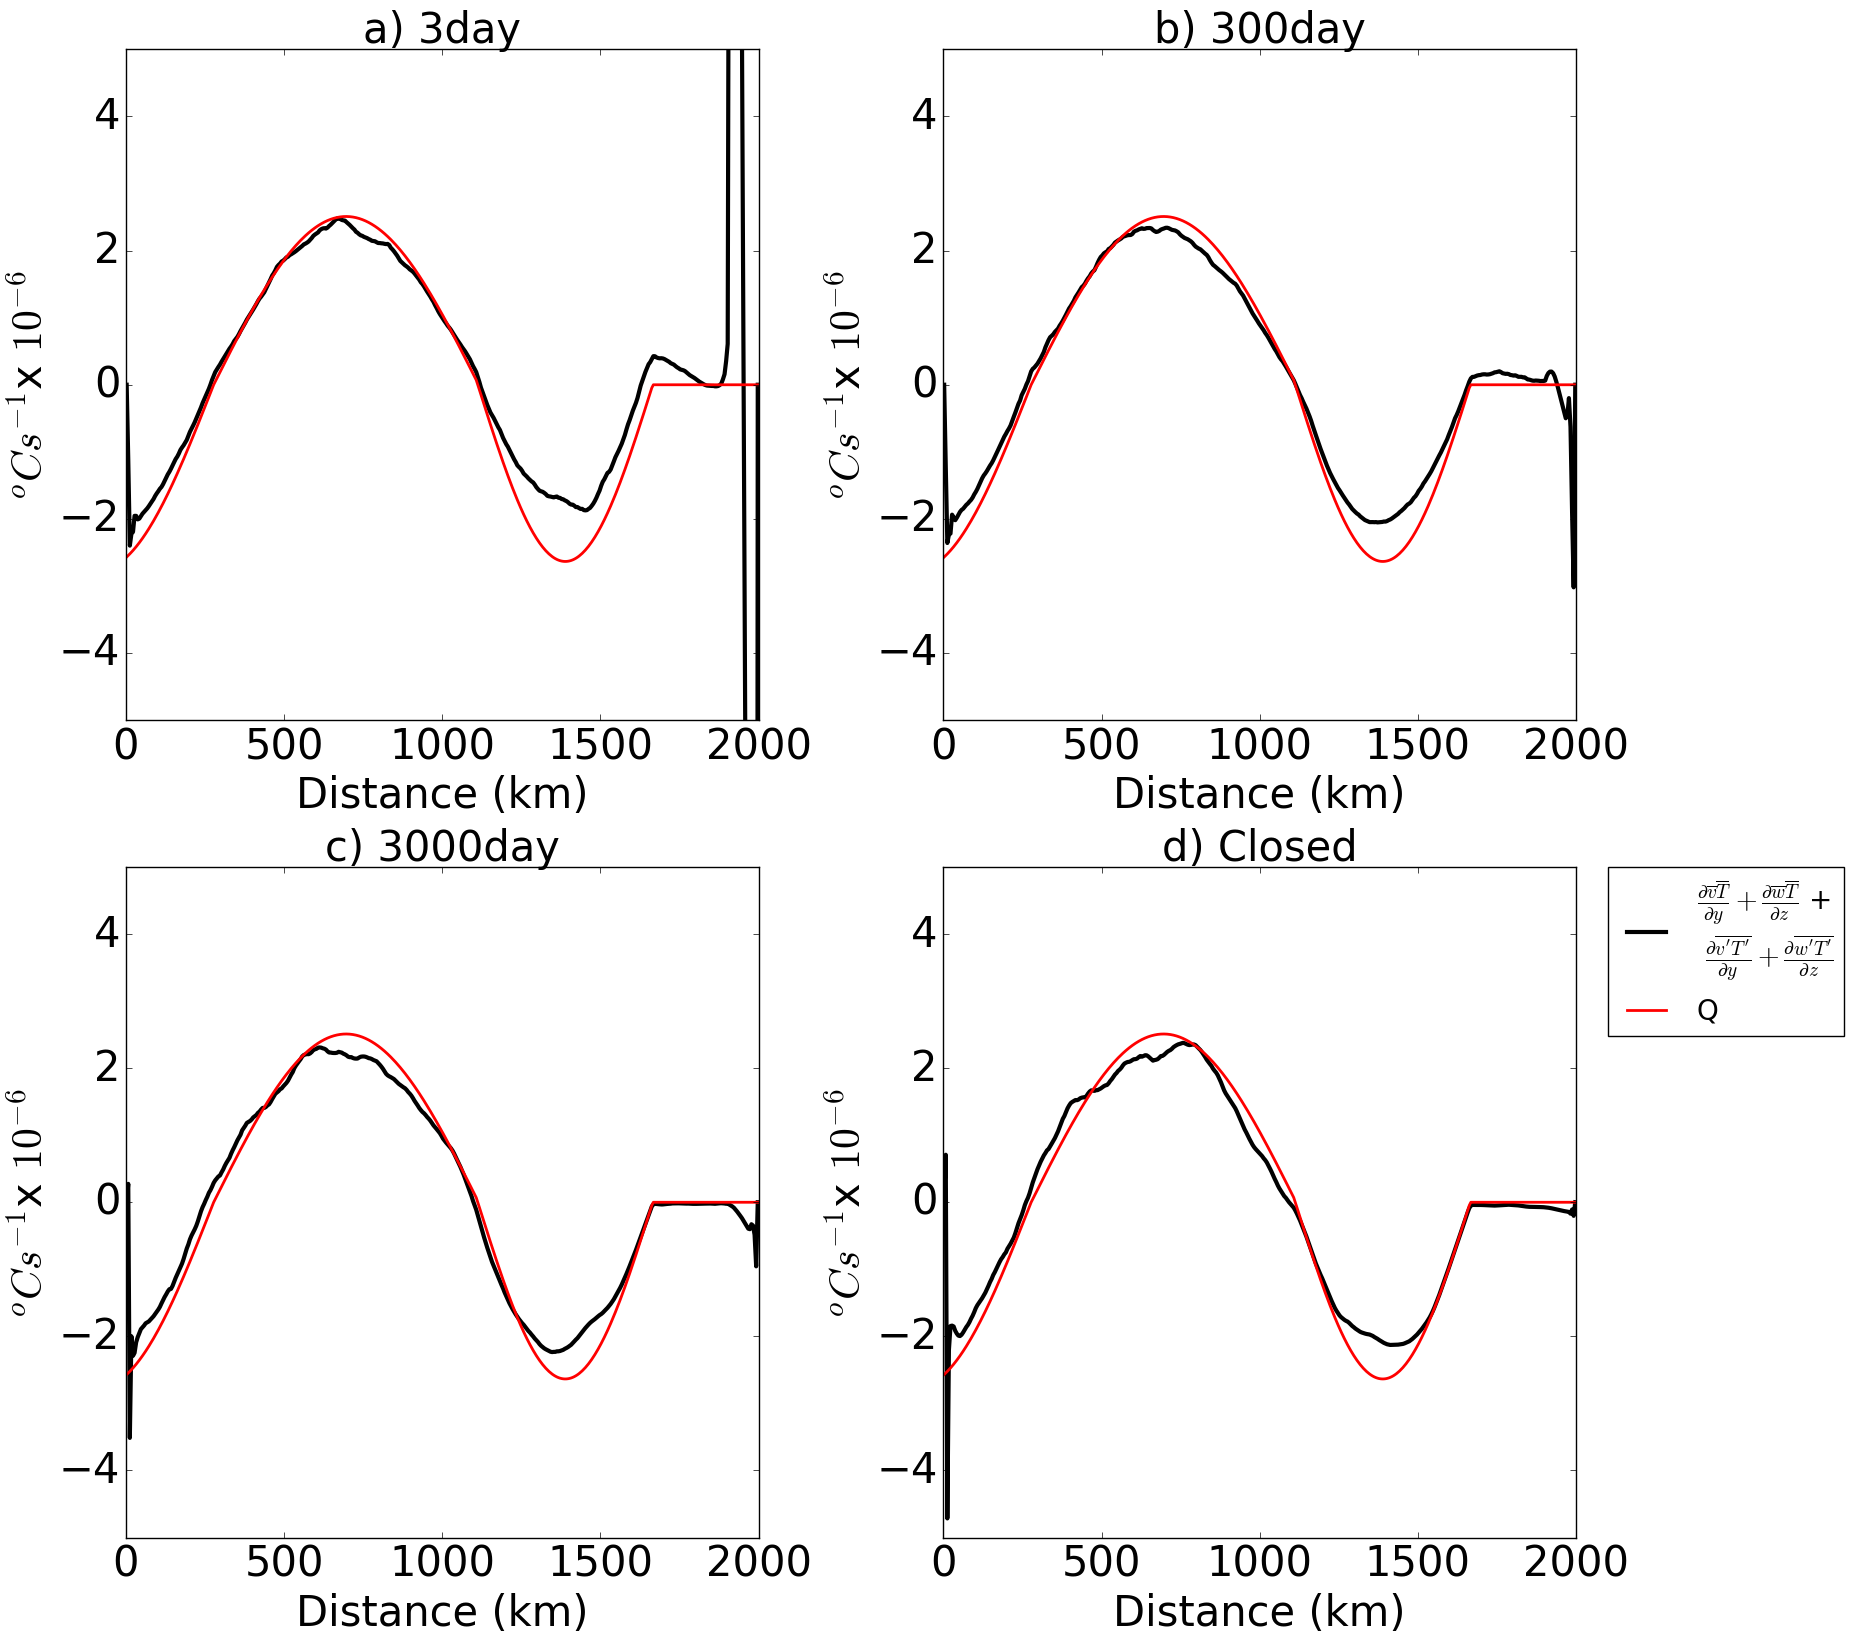

In [113]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVolv = 5000**2*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # and volume weight it       
    VT = (c.mnc('Tav_VT.nc','VVELTH'))*CellVolv 
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    V = (c.mnc('Tav.nc','VVEL'))*CellVolv 
    W = (c.mnc('Tav.nc','WVEL'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    # No slip bottom so W[-1]=0
    npad = ((0, 1), (0, 0), (0, 0))
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)*CellVolw
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)*CellVolw
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    dVTm = (VTbar[:,0:-1,:]-VTbar[:,1::,:]) # volume weighted  mean heat flux gradient
    dWTm = (WTbar[1::,:,:]-WTbar[0:-1,:,:]) # volume weighted mean heat flux gradient
    dVTe = (VpTp[:,0:-1,:]-VpTp[:,1::,:]) # volume weighted eddy heat flux gradient
    dWTe = (WpTp[1::,:,:]-WpTp[0:-1,:,:]) # volume weighted eddy heat flux gradient
    Div = -((((dVTm + dWTm+dVTe + dWTe)).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Div+Surcor)*10**6,'k',linewidth=3) # Divergence + free surface correction 
    p = plt.plot(c.yc/1000,(Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z }$ +'+' \n '+r'$\frac{\partial \overline{v^{\prime}T^{\prime}}}{\partial y } + \frac{\partial \overline{w^{\prime}T^{\prime}}}{\partial z } $',
                'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}

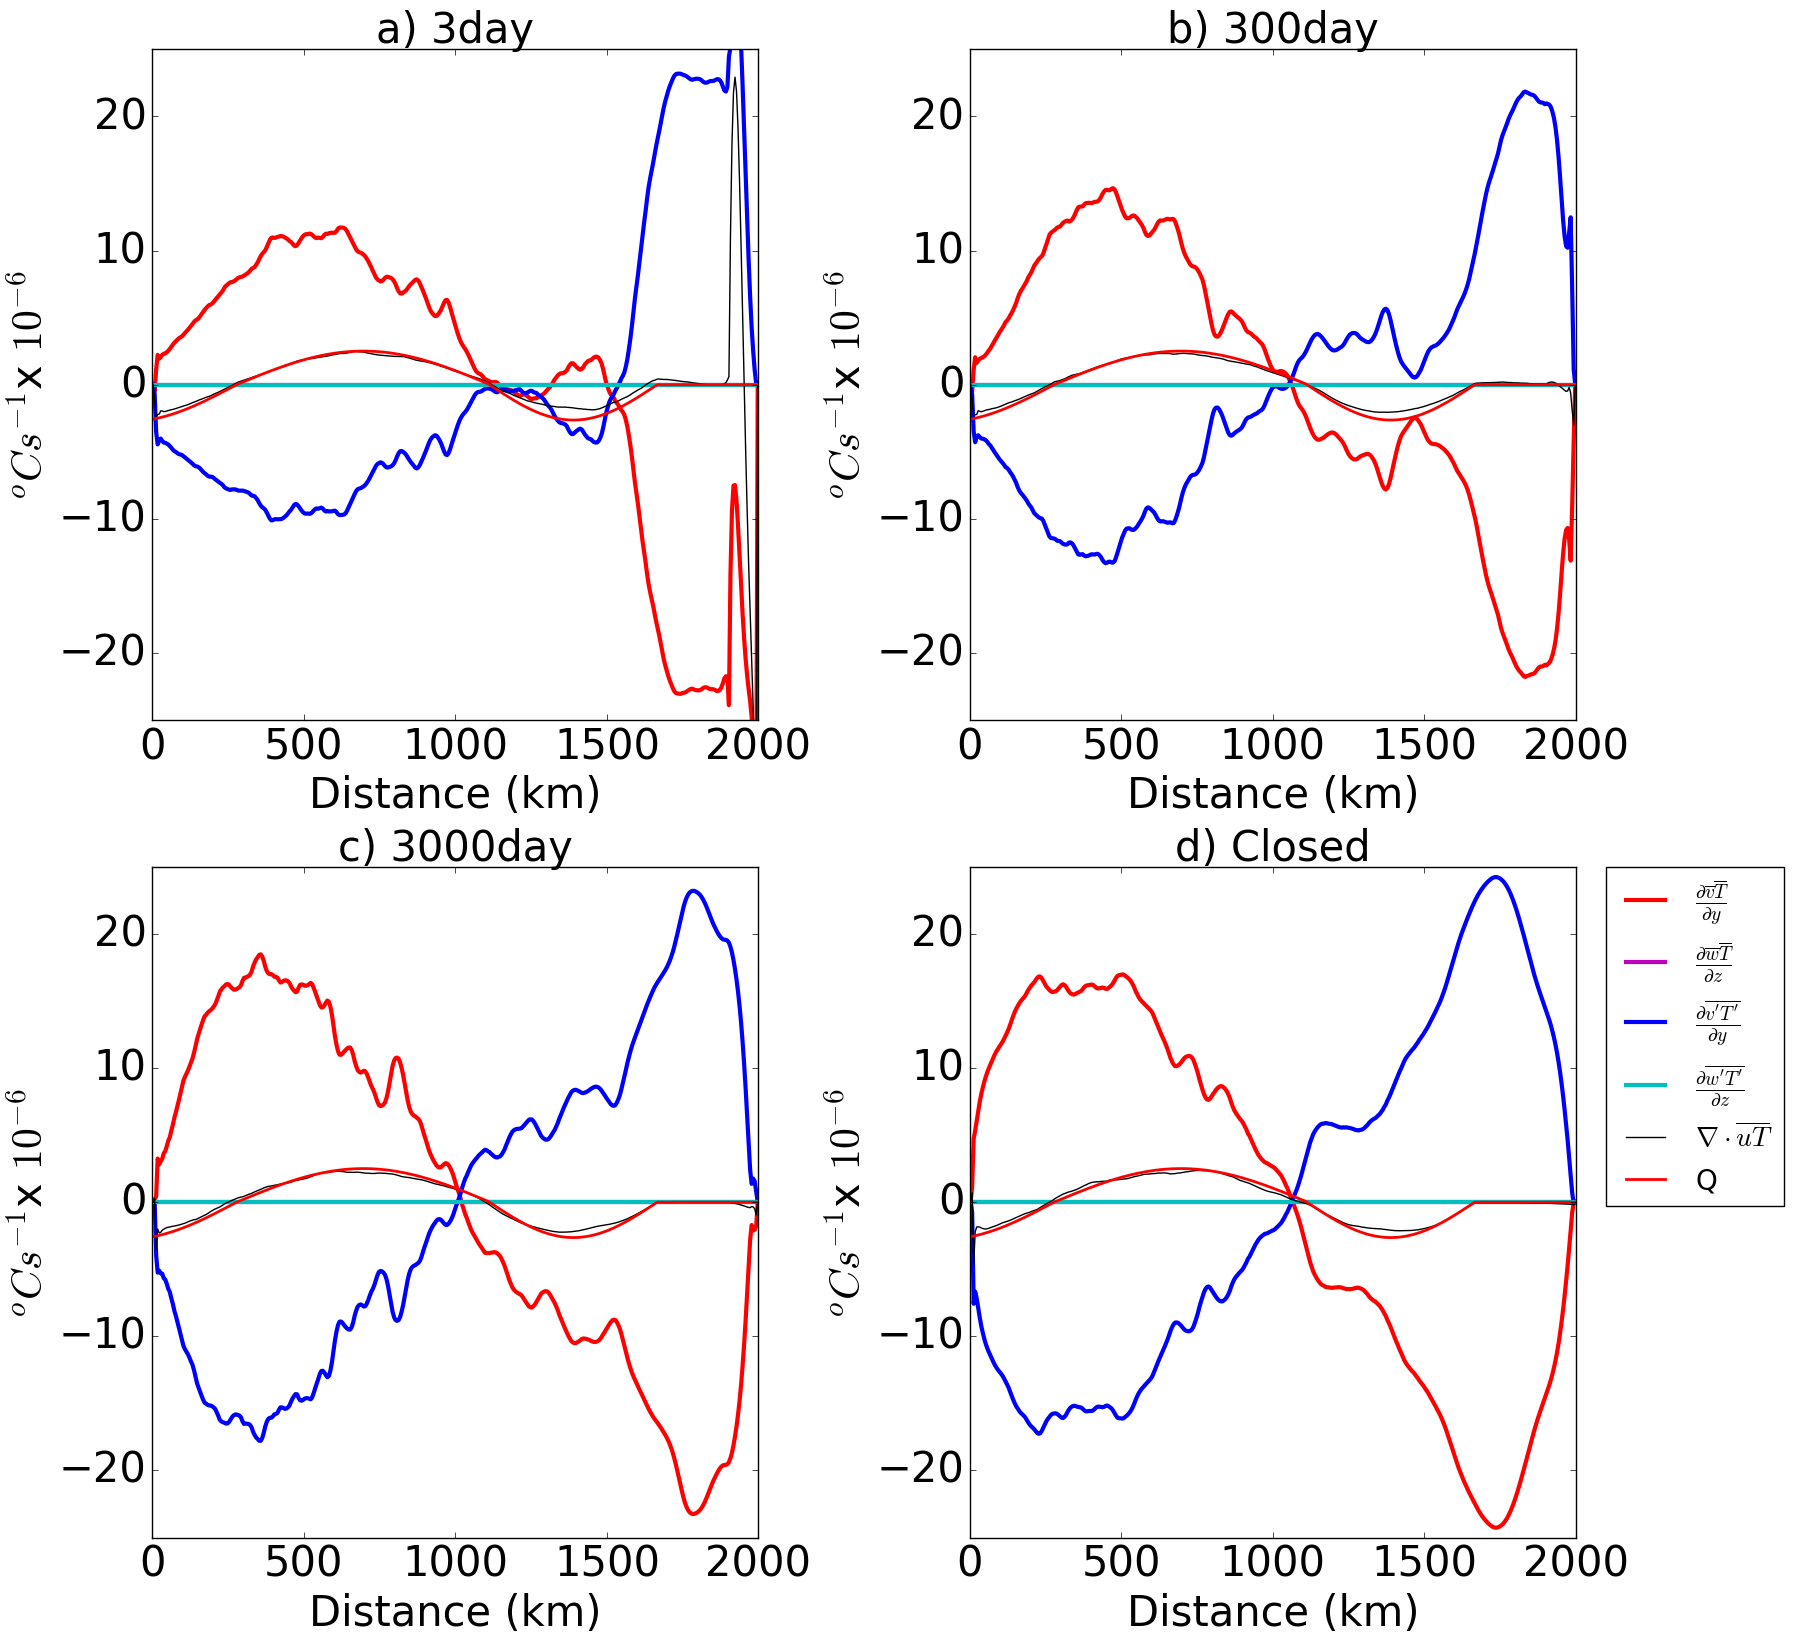

In [127]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVolv = 5000**2*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # and volume weight it       
    VT = (c.mnc('Tav_VT.nc','VVELTH'))*CellVolv 
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    V = (c.mnc('Tav.nc','VVEL'))*CellVolv 
    W = (c.mnc('Tav.nc','WVEL'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    # No slip bottom so W[-1]=0
    npad = ((0, 1), (0, 0), (0, 0))
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)*CellVolw
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)*CellVolw
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    dVTm = (VTbar[:,0:-1,:]-VTbar[:,1::,:]) # volume weighted  mean heat flux gradient
    dWTm = (WTbar[1::,:,:]-WTbar[0:-1,:,:]) # volume weighted mean heat flux gradient
    dVTe = (VpTp[:,0:-1,:]-VpTp[:,1::,:]) # volume weighted eddy heat flux gradient
    dWTe = (WpTp[1::,:,:]-WpTp[0:-1,:,:]) # volume weighted eddy heat flux gradient
    Div = -((((dVTm + dWTm+dVTe + dWTe)).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    Divmv = -((((dVTm )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    Divmw = -((((dWTm )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    Divev = -((((dVTe )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    Divew = -((((dWTe )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    if str(tau[Runs[i]]) == 'Closed':
        Divmv = -((((dVTm )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))*0.6
        Divmw = -((((dWTm )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))*0.6
        Divev = -((((dVTe )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))*0.6
        Divew = -((((dWTe )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))*0.6
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Divmv)*10**6,'r',linewidth=3) # Divergence + free surface correction 
    p = plt.plot(c.yc/1000,(Divmw)*10**6,'m',linewidth=3) # Divergence + free surface correction
    p = plt.plot(c.yc/1000,(Divev)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(Divew)*10**6,'c',linewidth=3)
    p = plt.plot(c.yc/1000,(Div+Surcor)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-25,25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\frac{\partial \overline{v}\overline{T}}{\partial y }$',r'$\frac{\partial \overline{w}\overline{T}}{\partial z }$ ',r'$\frac{\partial \overline{v^{\prime}T^{\prime}}}{\partial y }$',r'$ \frac{\partial \overline{w^{\prime}T^{\prime}}}{\partial z } $',
                r'$\nabla \cdot\overline{ uT}$','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial\overline{w} \overline{T}}{\partial z } + \frac{\partial \overline{v'T'}S_p}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } = \frac{\partial Q}{\partial z}+ \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }.
\end{equation}

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


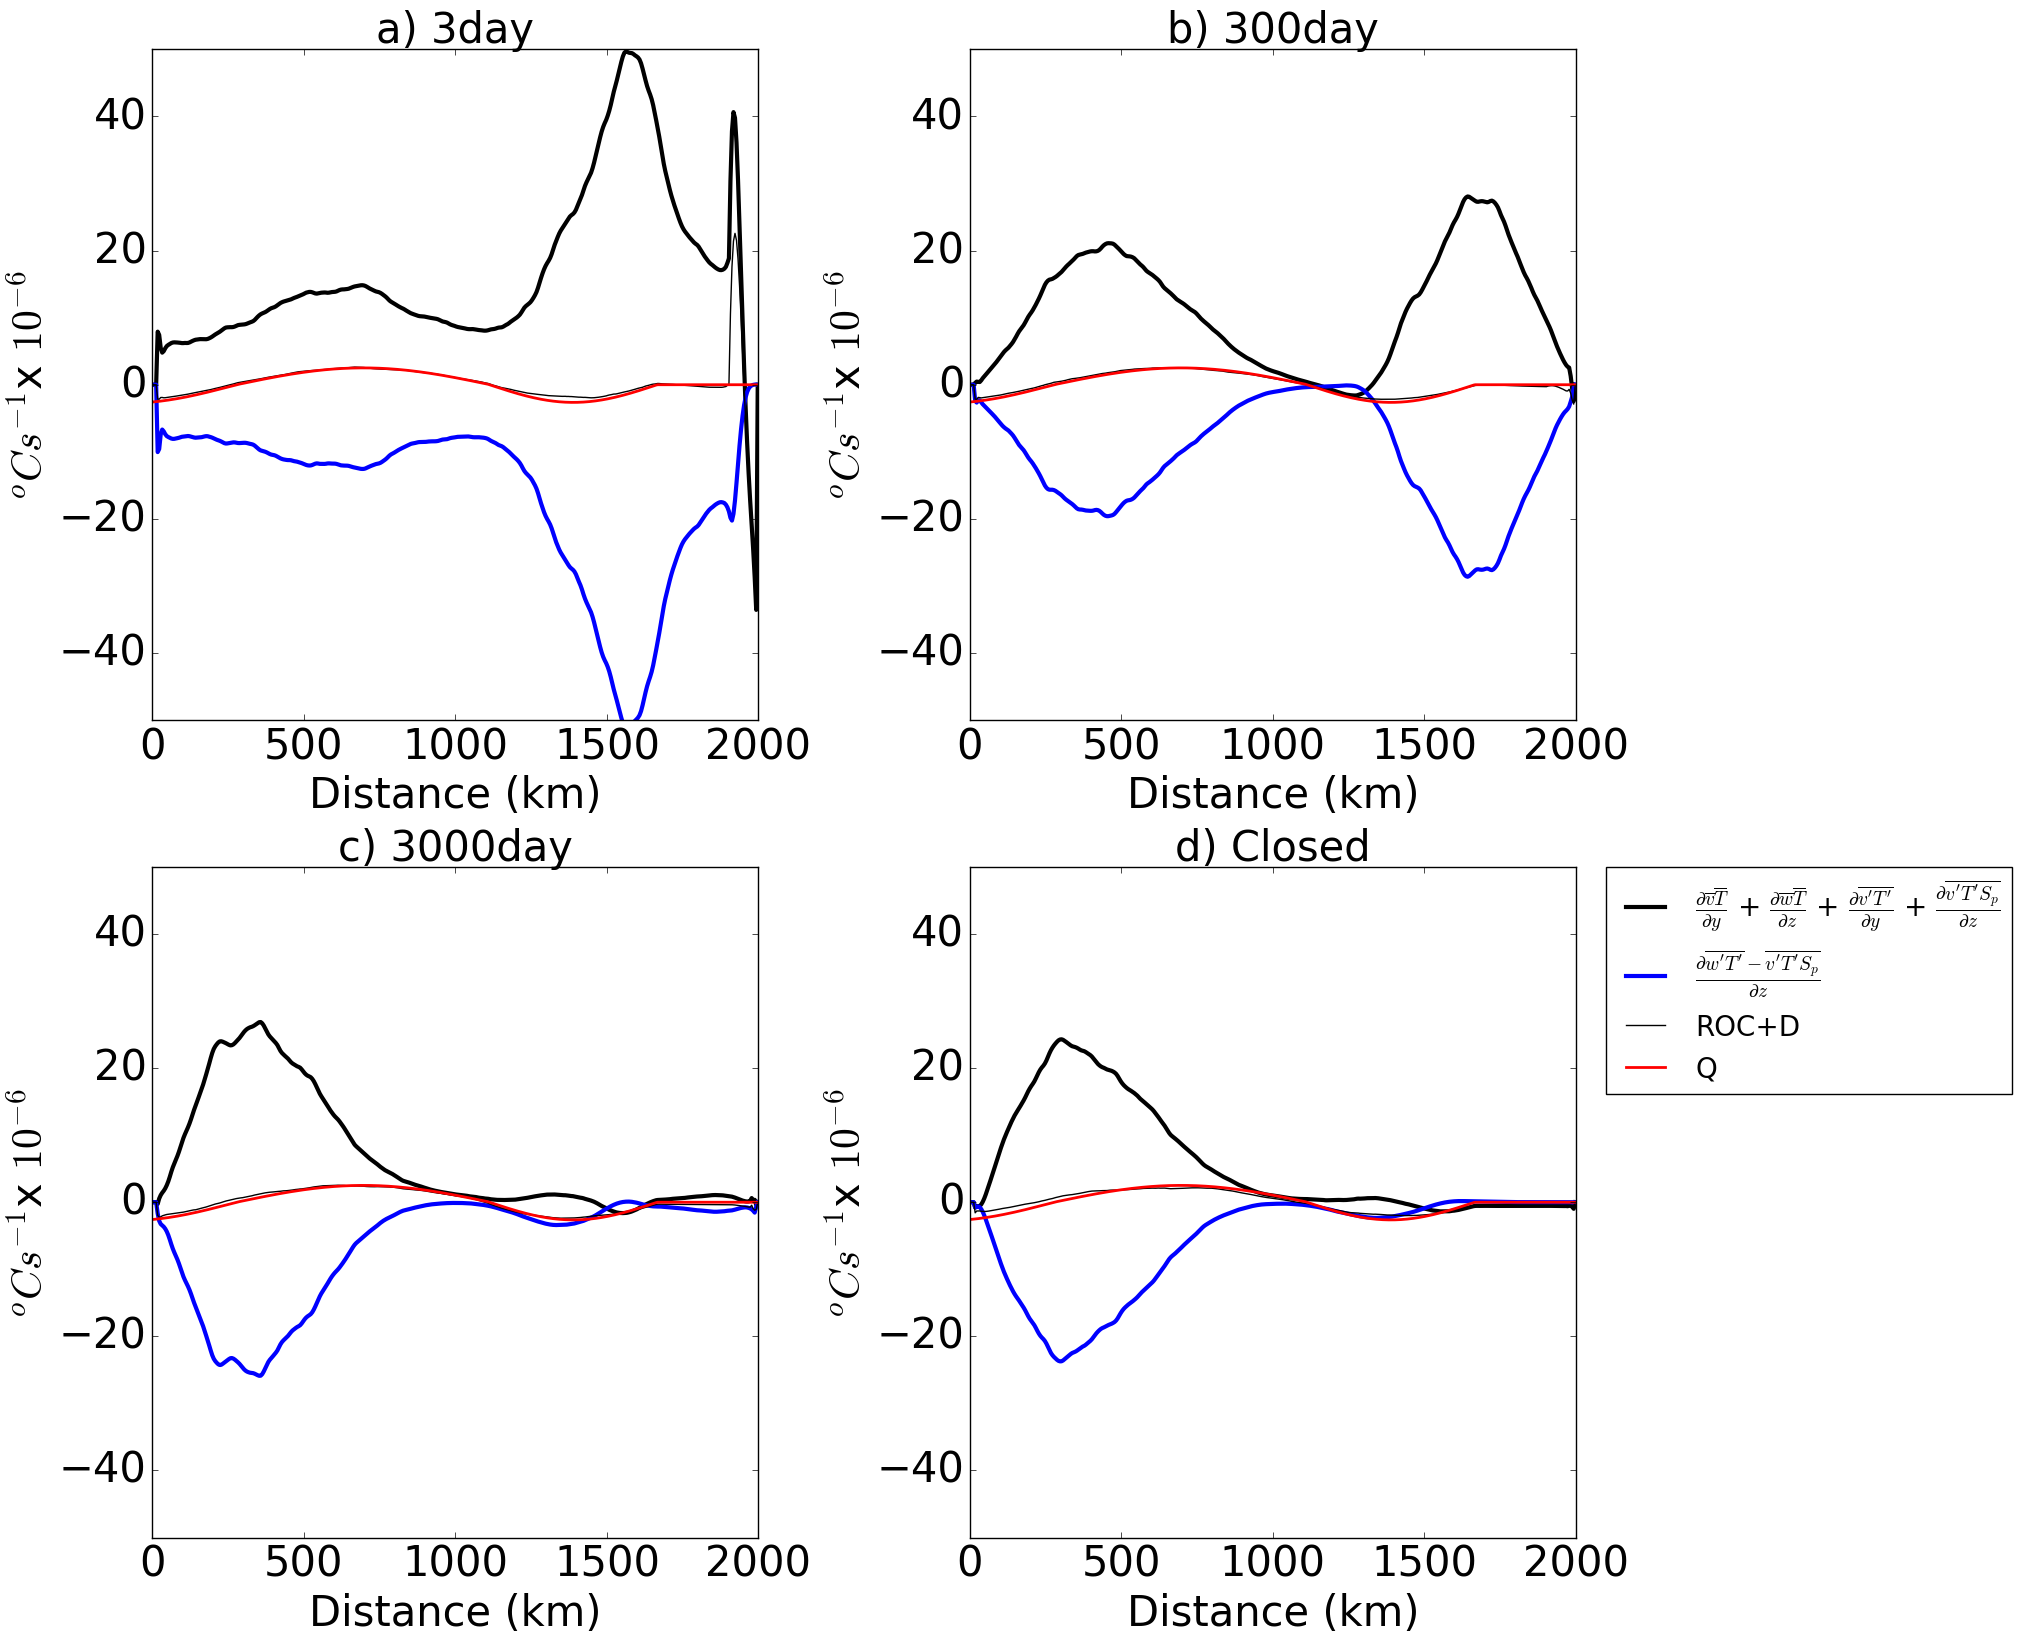

In [227]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    Div = -((((dVTm + dWTm+dVTe + dWTe)*CellVol/5000).sum(axis=2)).sum(axis=0))/(c.Lx)
    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
    D = -((((DE )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    if str(tau[Runs[i]]) == 'Closed':
        ROC = ROC*0.8
        D = D*0.8
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    
    p = plt.plot(c.yc/1000,(ROC)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(-Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-50,50)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$\frac{\partial \overline{v}\overline{T}}{\partial y }$ + $\frac{\partial \overline{w}\overline{T}}{\partial z }$ + $\frac{\partial \overline{v^{\prime}T^{\prime}}}{\partial y }$ + $ \frac{\partial \overline{v^{\prime}T^{\prime}S_{p}}}{\partial z } $',
                r'$ \frac{\partial \overline{w^{\prime}T^{\prime}}-\overline{v^{\prime}T^{\prime}S_{p}}}{\partial z } $','ROC+D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

plt.tight_layout()

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


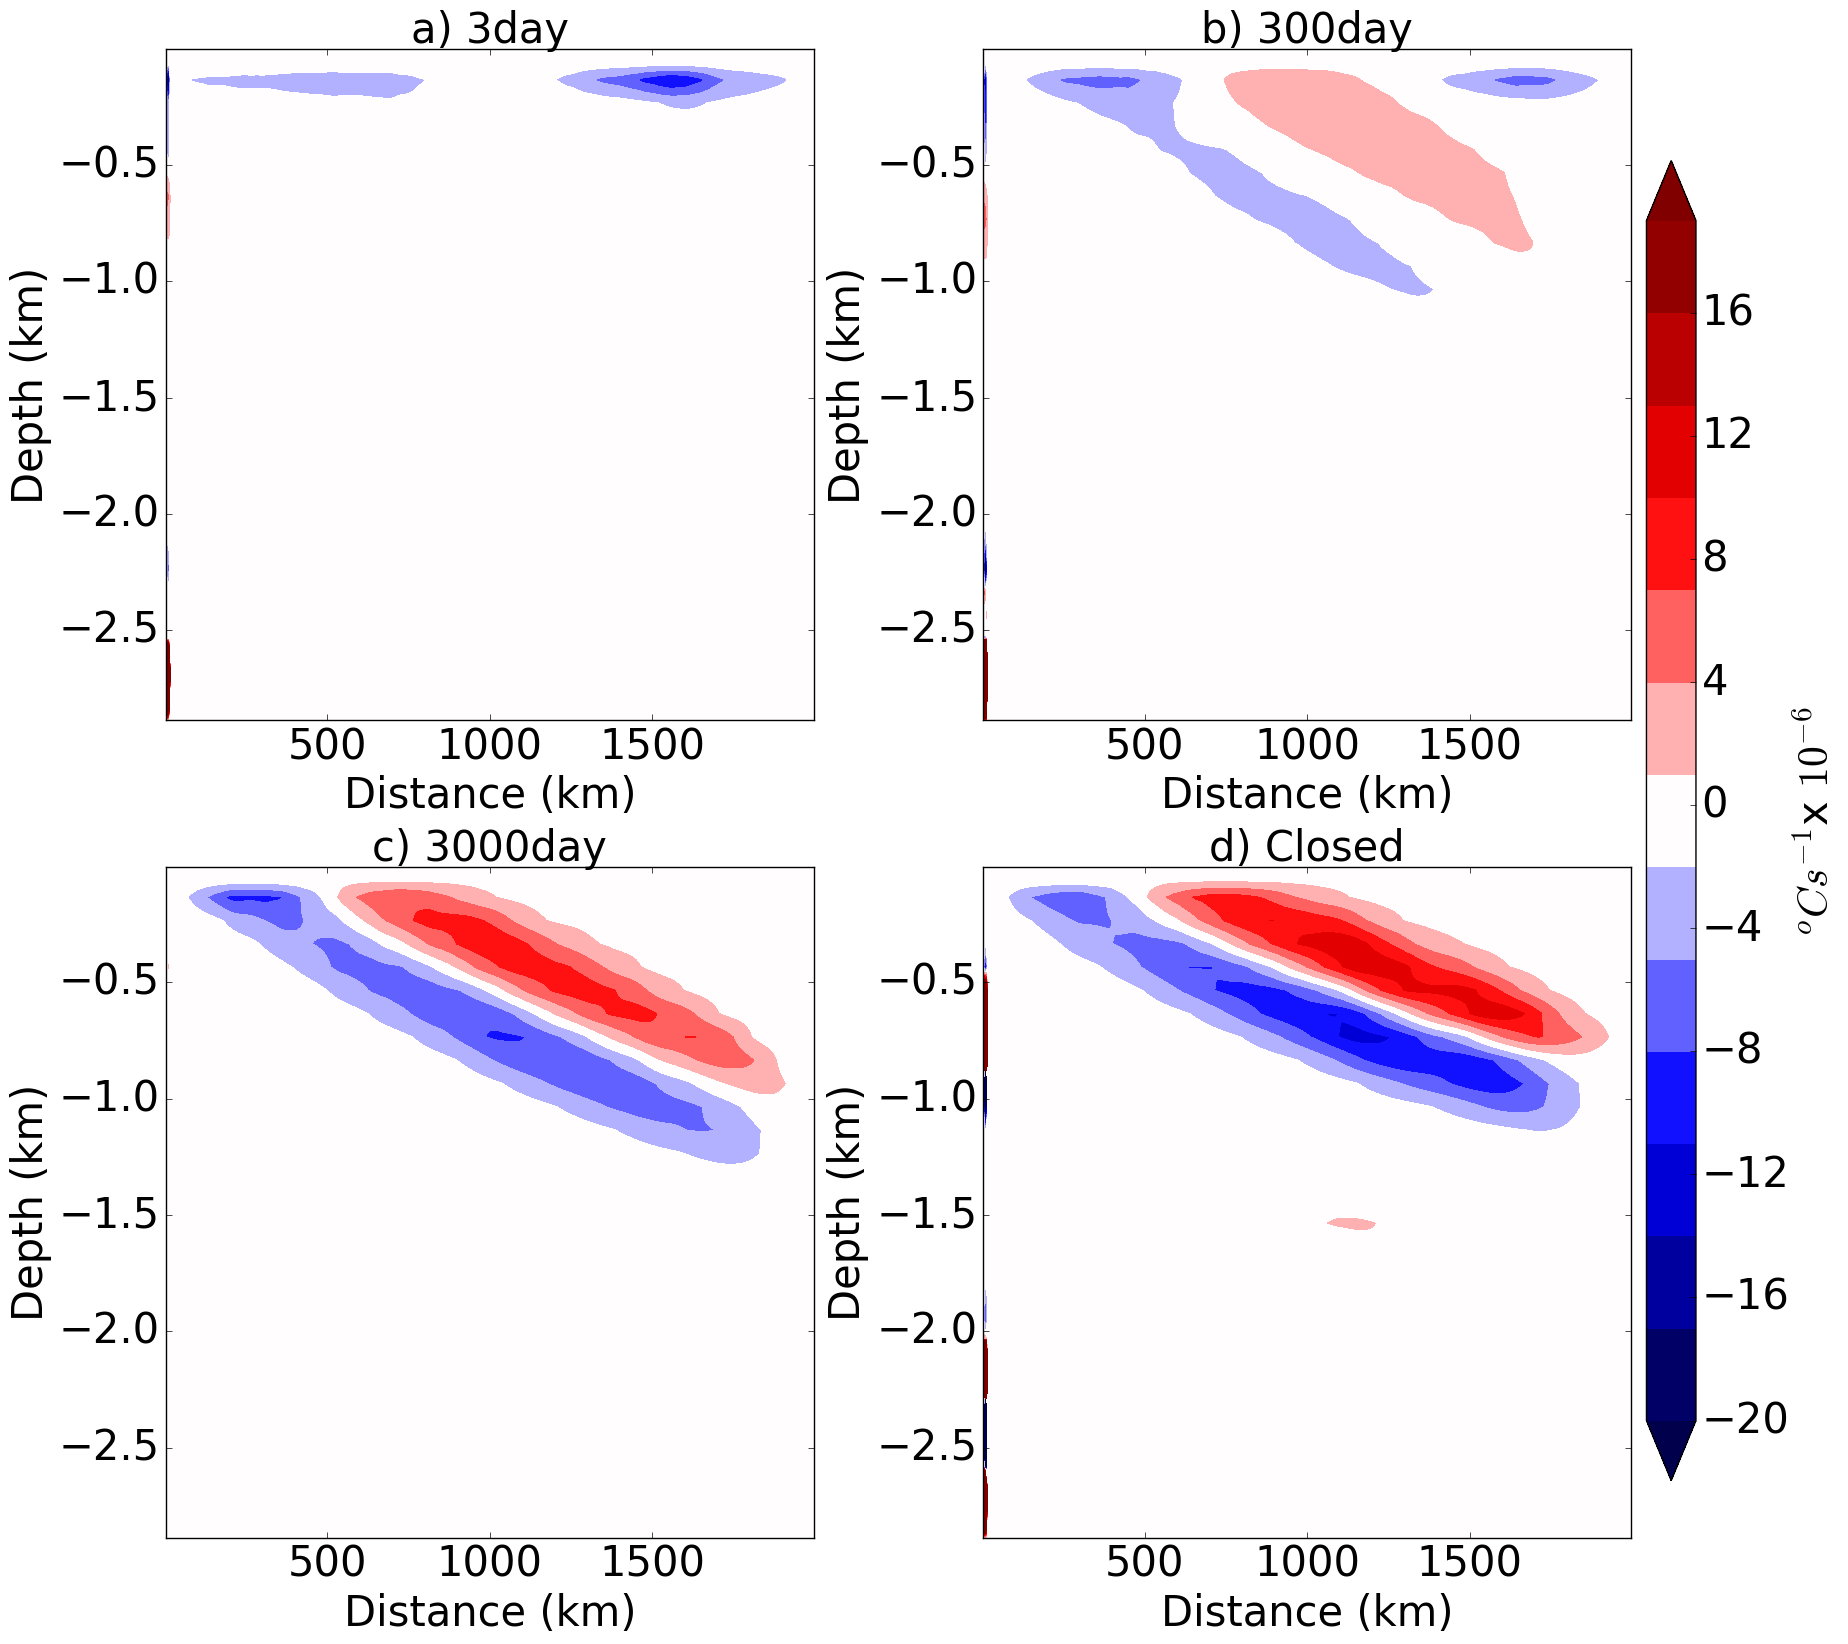

In [19]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)

 
    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
    D = -(((DE )).sum(axis=2))/np.sum(CellVol.mean(axis=2) )
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    if str(tau[Runs[i]]) == 'Closed':
        ROC = ROC*0.8
        D = D*0.8
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**6, np.arange(-1,1,0.15)*20, cmap=plt.cm.seismic, extend='both')

    
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax,ticks=np.arange(-1,1,0.2)*20)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)
plt.tight_layout()

ROC divergence

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


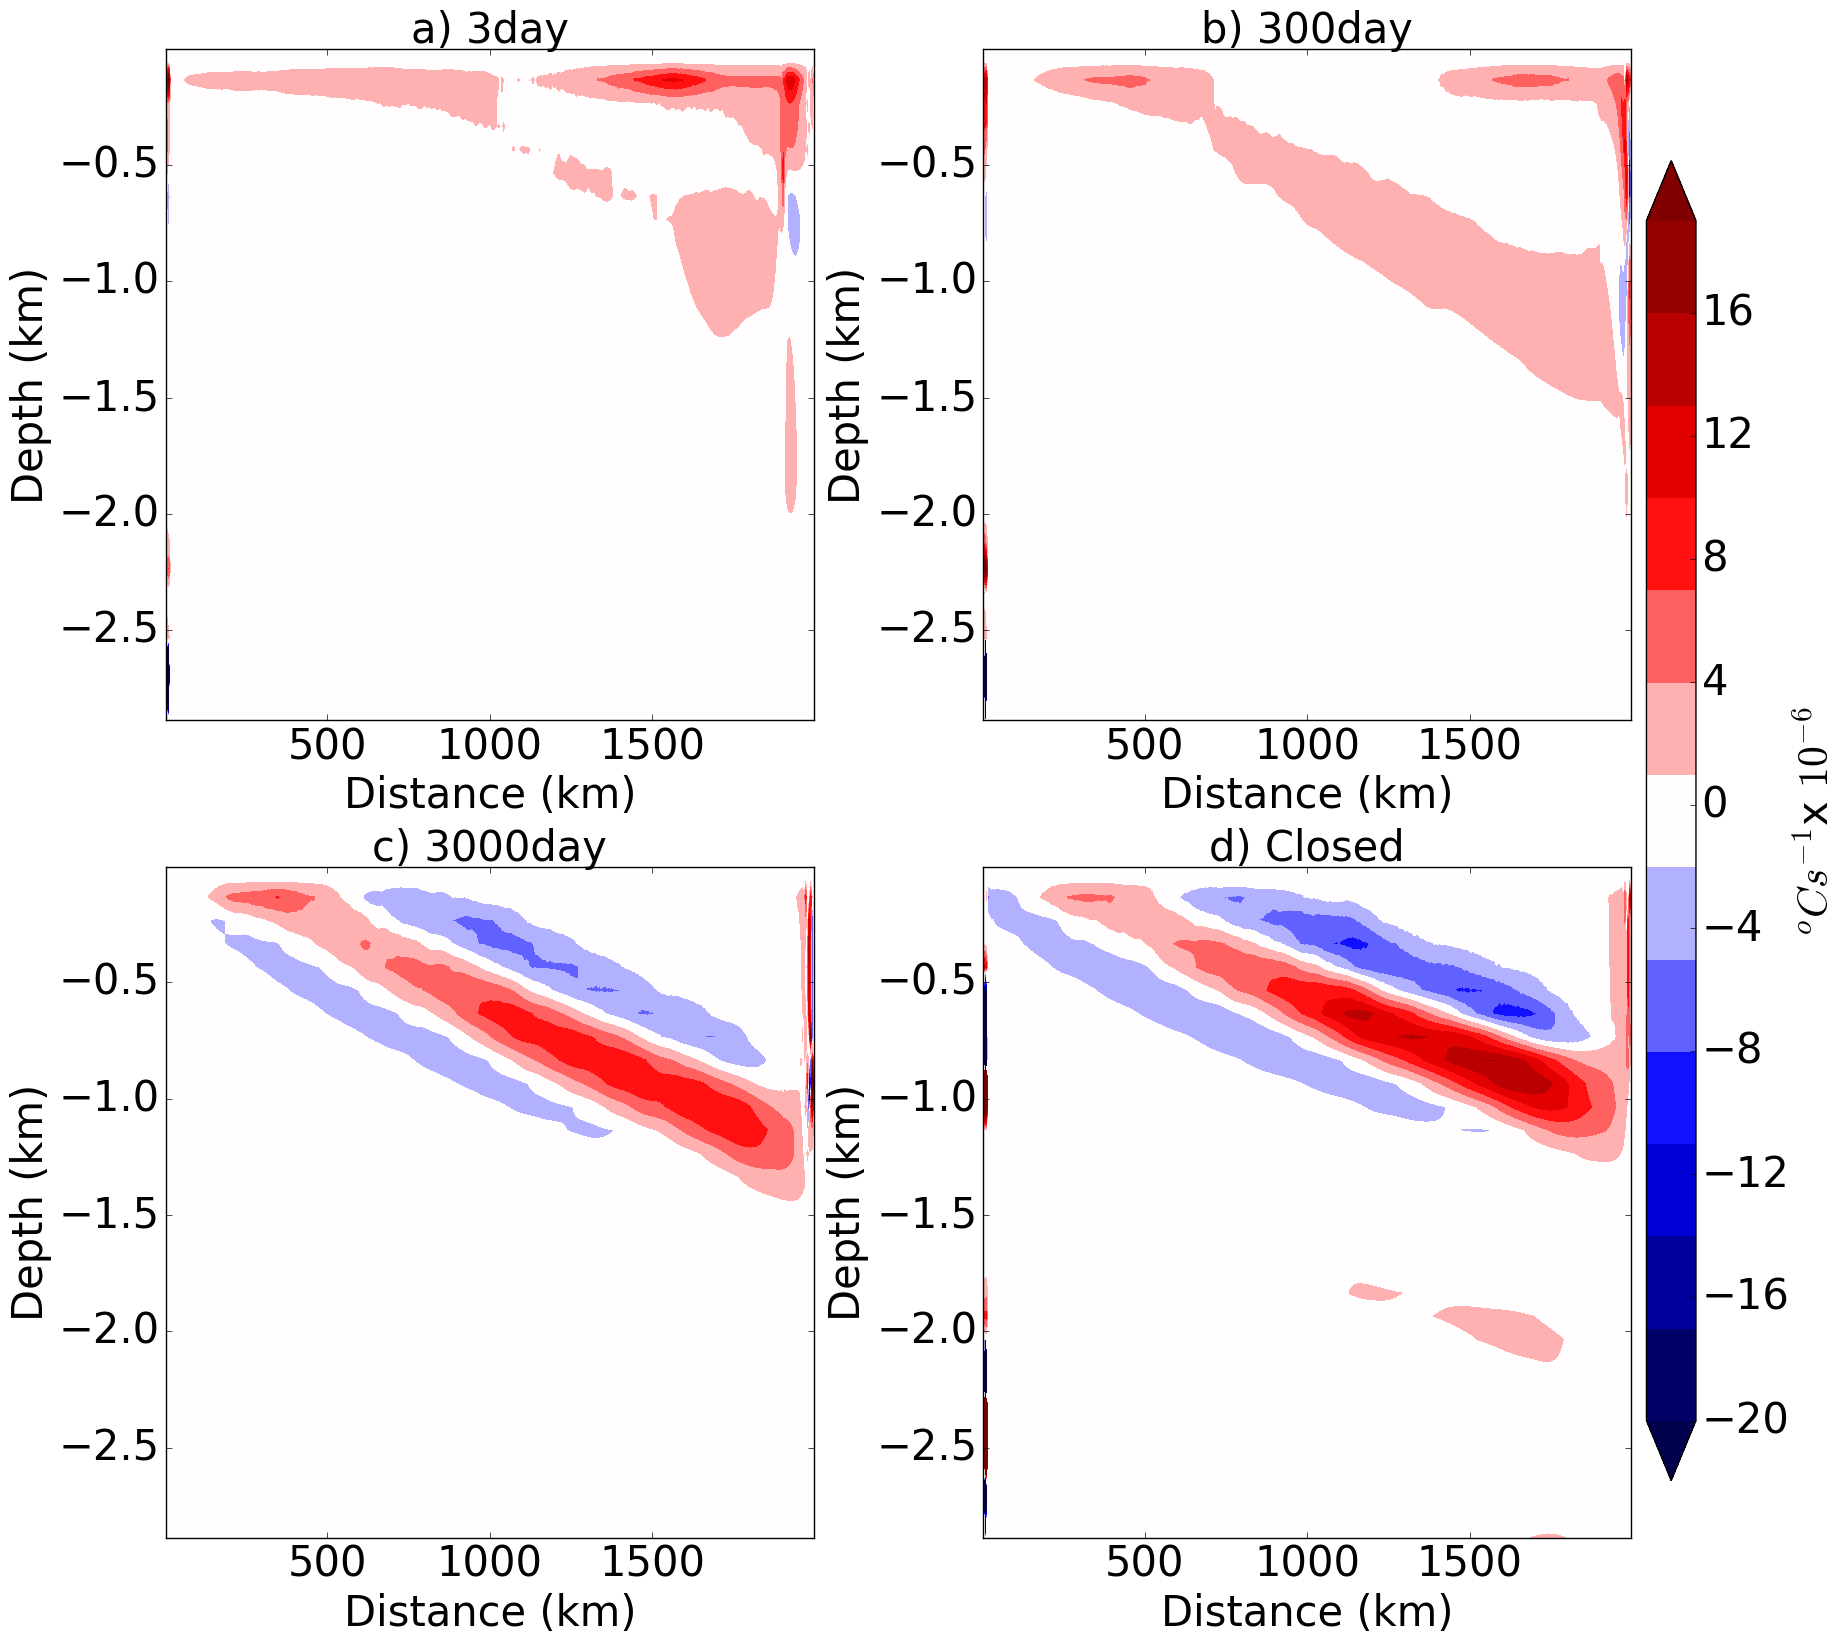

In [22]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)
    Ade = np.pad(Ade, pad_width=npad, mode='constant', constant_values=0)
 
    ROC = -((Ade+ dVTe + dVTbar + dWTbar).sum(axis=2))/sum(CellVol.mean(axis=2))
    D = -(((DE )).sum(axis=2))/np.sum(CellVol.mean(axis=2) )
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    if str(tau[Runs[i]]) == 'Closed':
        ROC = ROC*0.8
        D = D*0.8
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                ROC*10**6, np.arange(-1,1,0.15)*20, cmap=plt.cm.seismic, extend='both')

    
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax,ticks=np.arange(-1,1,0.2)*20)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)
plt.tight_layout()

\begin{equation}
\psi _{res} = \frac{\overline{w_{res}T}}{T_{y}}, \quad \quad \psi _{res} = \frac{\overline{v_{res}T}}{T_{z}},
\end{equation}

We can actually write:

\begin{equation}
-\frac{\partial \Psi _{res} T_y }{\partial z}  + \frac{\partial \Psi _{res} T_z }{\partial y} = \frac{\partial Q}{\partial z}- \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }.
\end{equation}

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


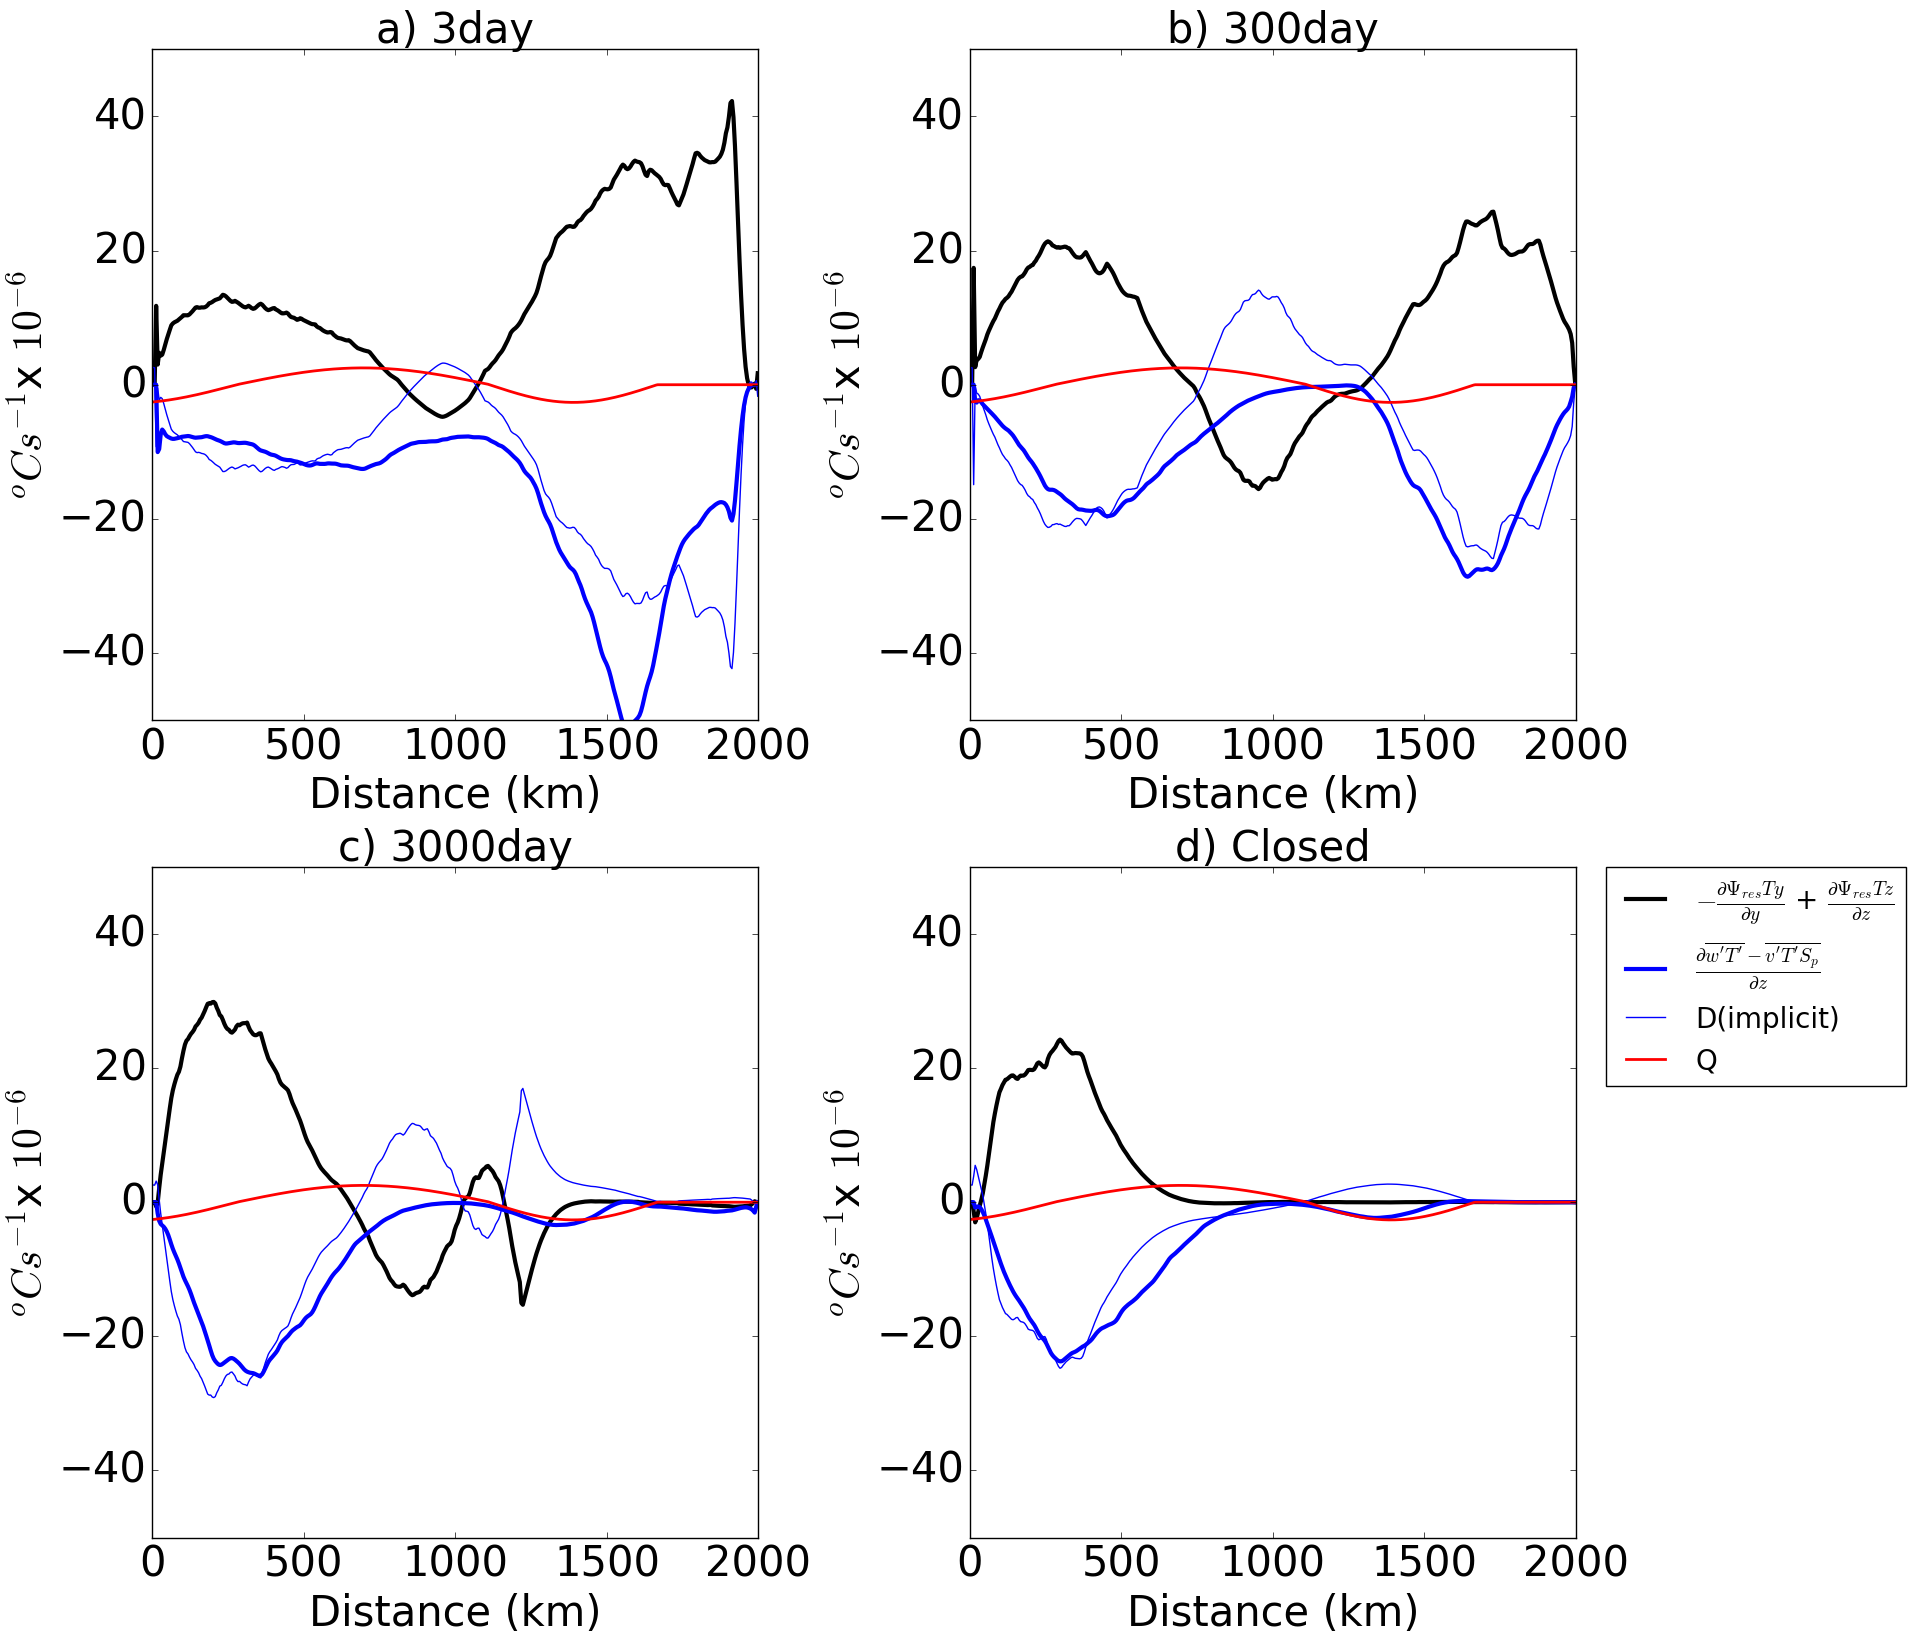

In [395]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-6]=10**-6
    Sp[isinf(Sp)]=10**-6
    Sp[isnan(Sp)]=10**-6
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    D = -((((DE )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    
    # ROC 
    psiz = c.get_psi_iso_z()
    # Psi is m^3/s so divide by Area
    # So remove volume 
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])#*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])#*CellVol
   
    dPz = -c.ddz_cgrid_centered((psiz)*Ty.sum(axis=2))
    dPy =  c.ddy_cgrid_centered((psiz)*Tz.sum(axis=2))
    ROC = ((((dPz+dPy))).sum(axis=0))/(c.Lx*c.H)
    if str(tau[Runs[i]]) == 'Closed':
        ROC = ROC*0.8
        D = D*0.8
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    
    p = plt.plot(c.yc/1000,(ROC)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred-ROC-Surcor)*10**6,'b',linewidth=1)
    p = plt.plot(c.yc/1000,(-Psipred)*10**6,'r',linewidth=2)
    #p = plt.plot(c.yc/1000,(-)*10**6,'b',linewidth=1)
    plt.ylim(-50,50)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$-\frac{\partial \Psi_{res}Ty}{\partial y }$ + $\frac{\partial \Psi_{res} Tz}{\partial z }$',
                r'$ \frac{\partial \overline{w^{\prime}T^{\prime}}-\overline{v^{\prime}T^{\prime}S_{p}}}{\partial z } $','D(implicit)','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

plt.tight_layout()


\begin{equation}
-\frac{\partial \Psi _{res} T_y }{\partial z}  + \frac{\partial \Psi _{res} T_z }{\partial y} = \frac{\partial Q}{\partial z } + \frac{\partial \overline{w}\overline{T}\frac{Tz}{Ty}+\overline{v}\overline{T}}{\partial z}.
\end{equation}

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


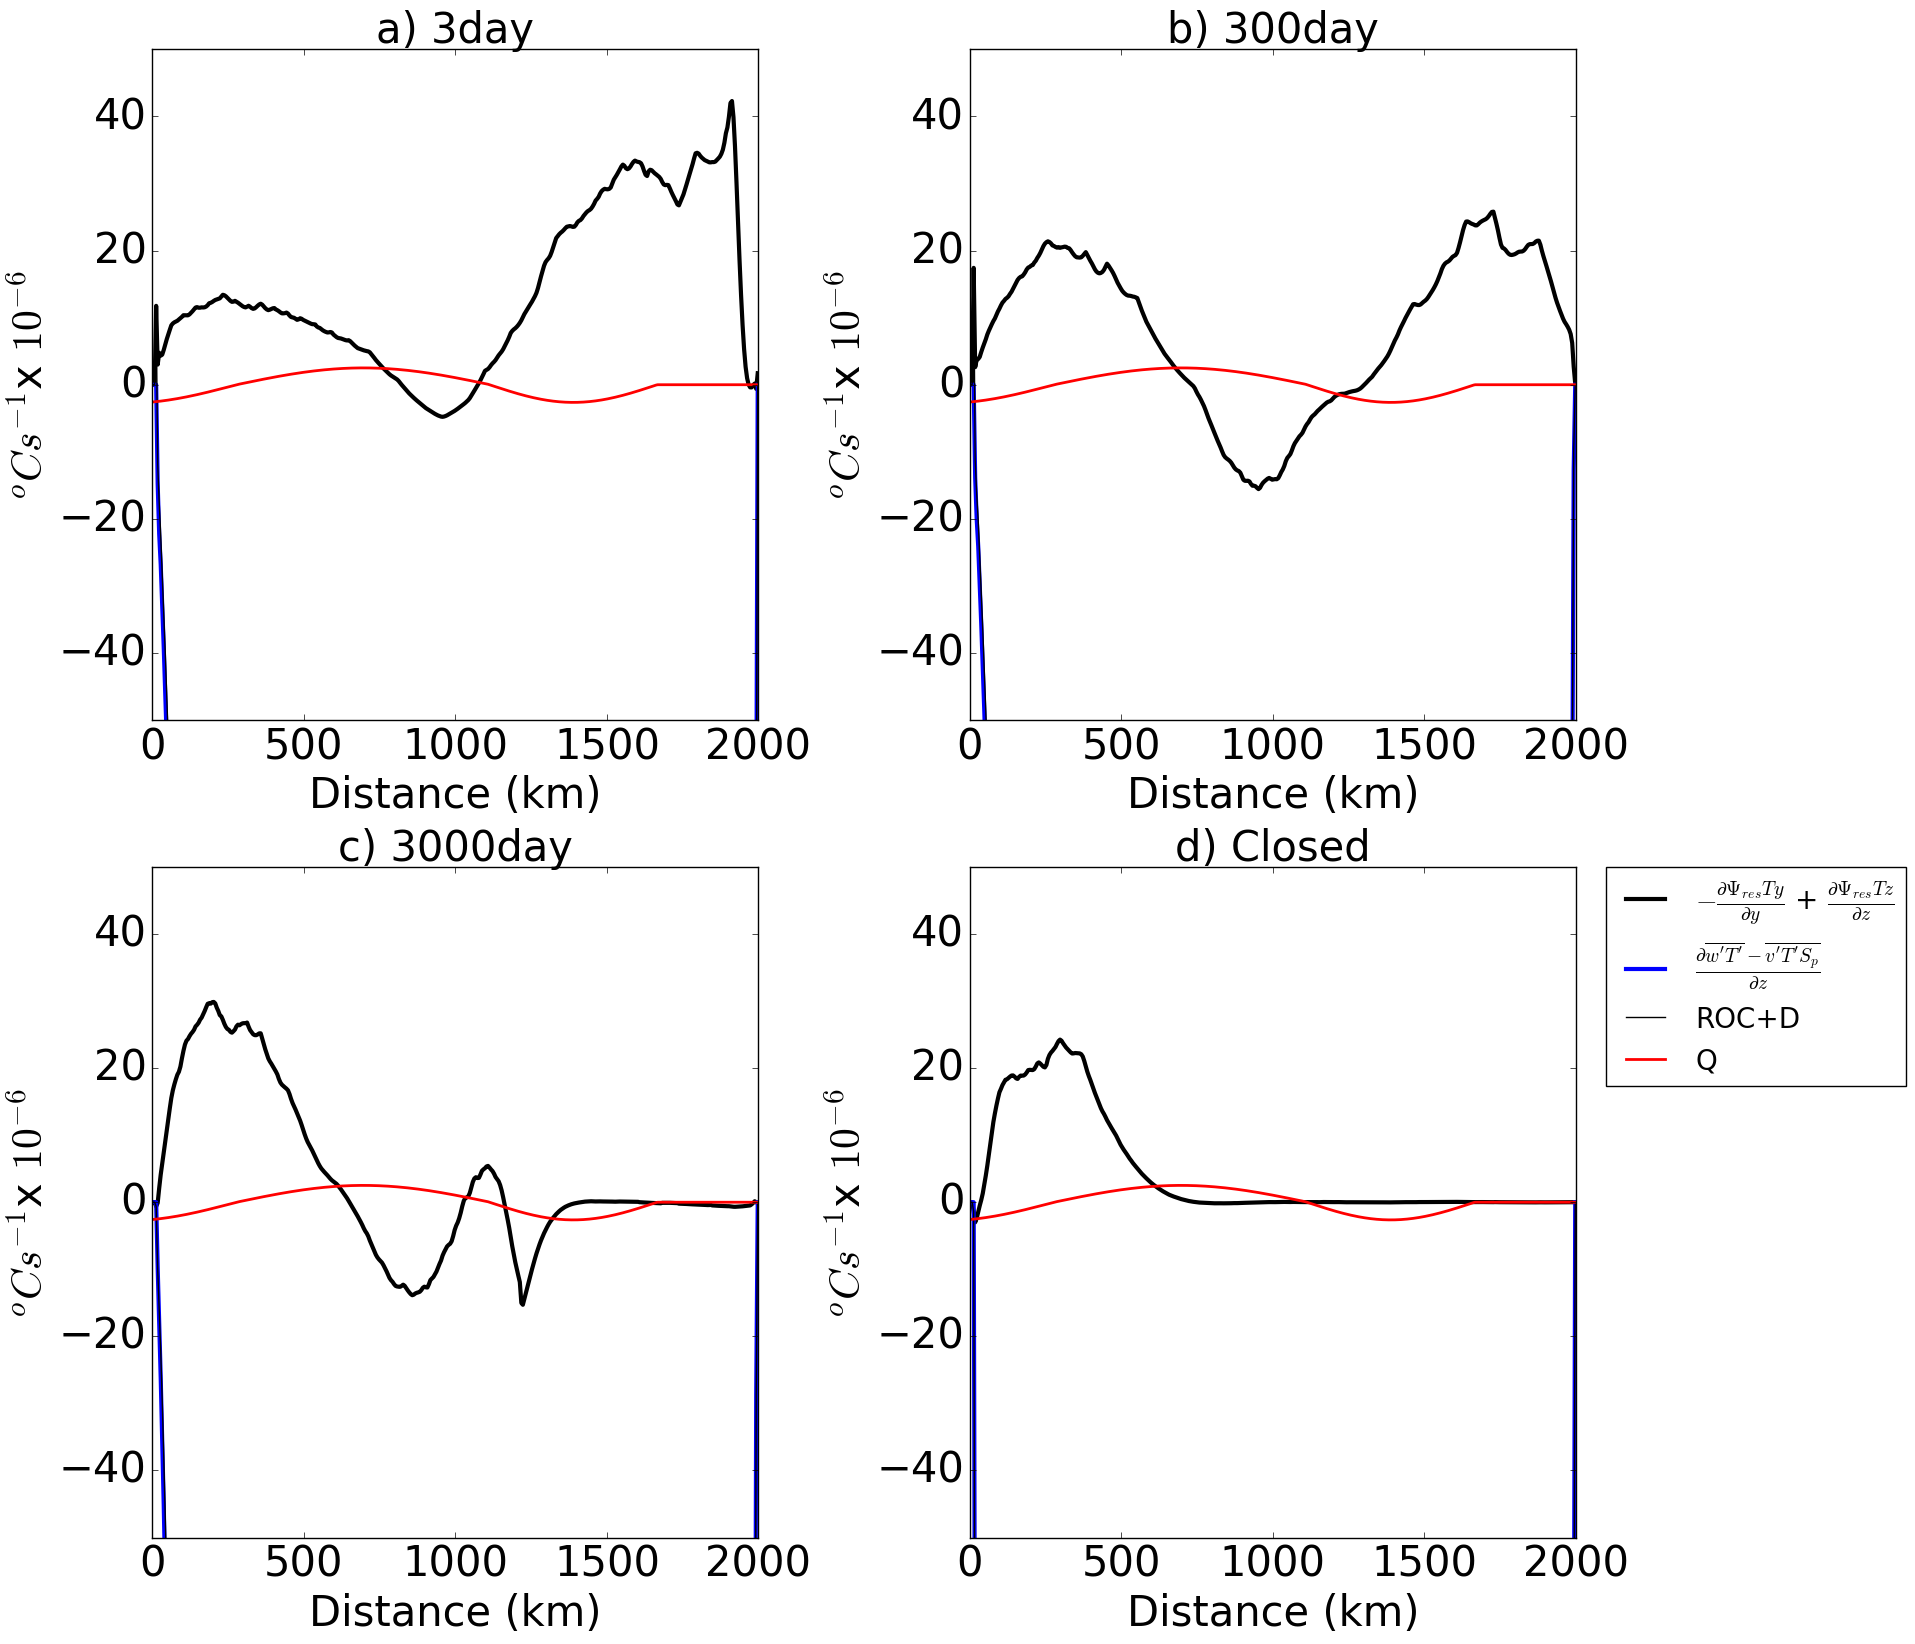

In [390]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-6]=10**-6
    Sp[isinf(Sp)]=10**-6
    Sp[isnan(Sp)]=10**-6
   
    dWTbarSp = ((WTbar*utils.cgrid_to_wgrid(Sp))[1::,:,:]-(WTbar*utils.cgrid_to_wgrid(Sp))[0:-1,:,:])*CellVol
    dVTbarz = (utils.cgrid_to_wgrid(c.vgrid_to_cgrid(VTbar))[1::,:,:] 
           -utils.cgrid_to_wgrid(c.vgrid_to_cgrid(VTbar))[0:-1,:,:])*CellVol
    DE = dWTbarSp + dVTbarz
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    D = ((((DE )).sum(axis=2)).sum(axis=0))/sum(CellVol.mean(axis=2))
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    
    # ROC 
    psiz = c.get_psi_iso_z()
    # Psi is m^3/s so divide by Area
    # So remove volume 
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])#*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])#*CellVol
   
    dPz = -c.ddz_cgrid_centered((psiz)*Ty.sum(axis=2))
    dPy =  c.ddy_cgrid_centered((psiz)*Tz.sum(axis=2))
    ROC = ((((dPz+dPy))).sum(axis=0))/(c.Lx*c.H)
    if str(tau[Runs[i]]) == 'Closed':
        ROC = ROC*0.8
        D = D*0.8
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    
    p = plt.plot(c.yc/1000,(ROC)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(-Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-50,50)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd=plt.legend([r'$-\frac{\partial \Psi_{res}Ty}{\partial y }$ + $\frac{\partial \Psi_{res} Tz}{\partial z }$',
                r'$ \frac{\partial \overline{w^{\prime}T^{\prime}}-\overline{v^{\prime}T^{\prime}S_{p}}}{\partial z } $','ROC+D','Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

plt.tight_layout()

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less


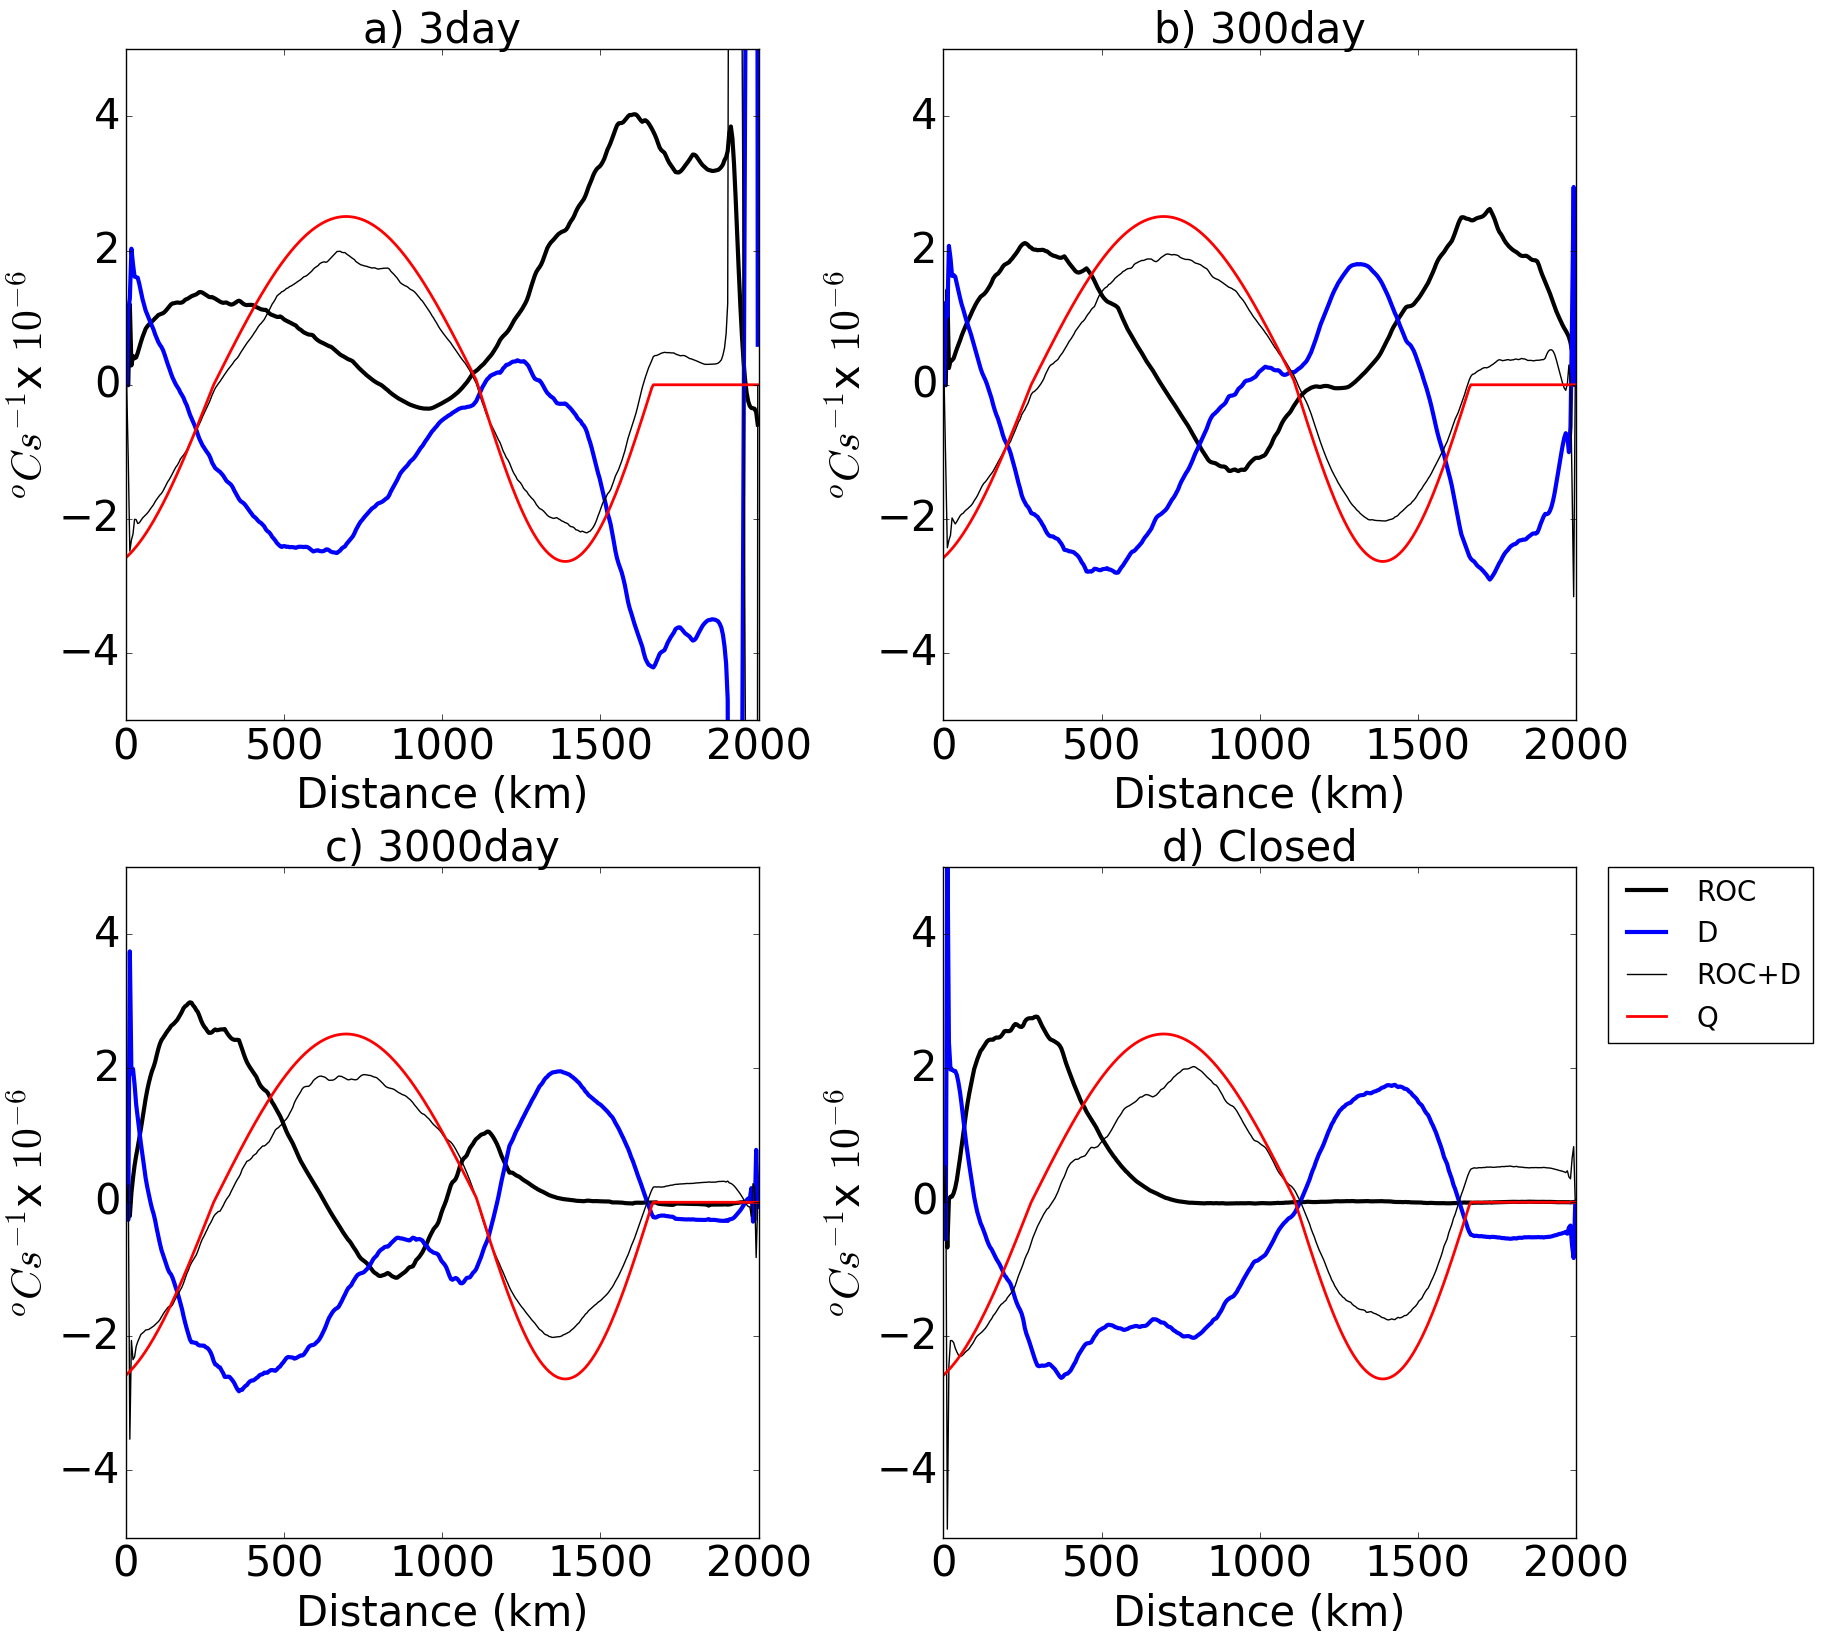

In [25]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    T = (c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
   

    #g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.sum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    #25 = 5000/200
    dx = 5000
    nx = 200
    #Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).mean(axis=2)/nx - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/dx)
    #Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).mean(axis=2)/nx - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/dx)
    Dz = ((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).sum(axis=2) - dPy
    Dy =  - dPz + ((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).sum(axis=2)
    D = -np.sum((Dz+Dy)/np.sum(CellVol.mean(axis=2)),axis=0)
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    #D = -5000*np.sum((Dy+Dz)/np.sum(CellVol.mean(axis=2)),axis=0)
 
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)

    p = plt.plot(c.yc/1000,-ROC*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(-D+ROC+Surcor)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(-Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


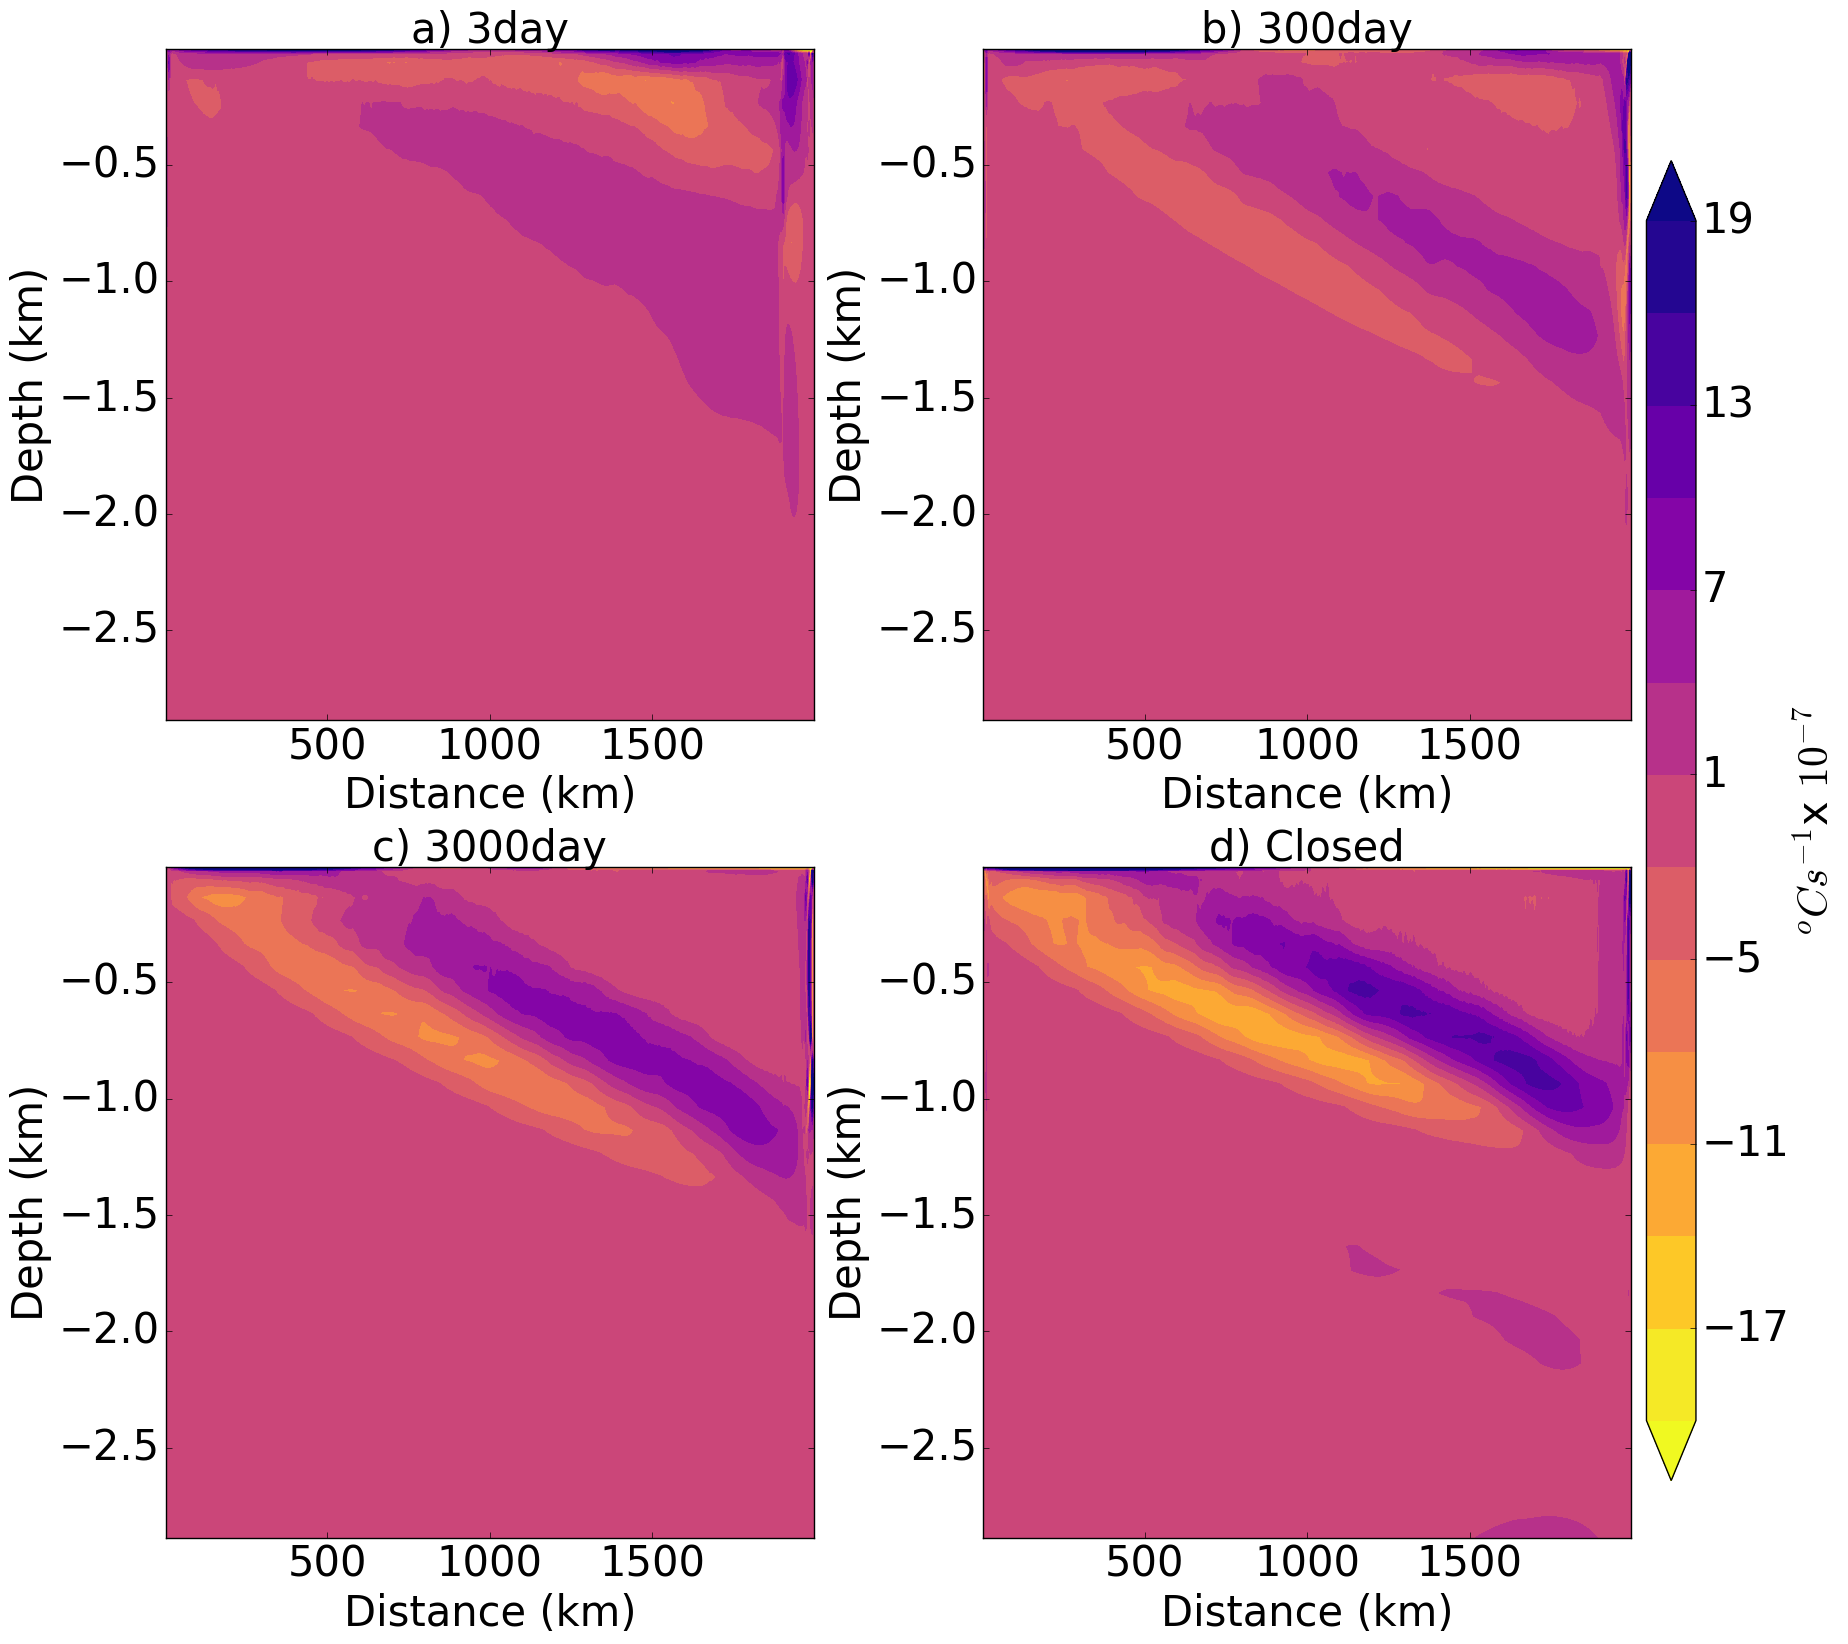

In [13]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
   

    #g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.cumsum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    #Dz = ((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).sum(axis=2) - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    #Dy = ((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).sum(axis=2) - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    dx = 5000
    nx = 200
    Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).mean(axis=2)/nx - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/dx)
    Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).mean(axis=2)/nx - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/dx)
    
    D = (Dz+Dy)/np.sum(CellVol.mean(axis=2))
 
    ax = fig.add_subplot(2, 2, i+1)
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**7, np.arange(-1,1,0.15)*20, cmap=plt.cm.plasma_r, extend='both')

    
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-7}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


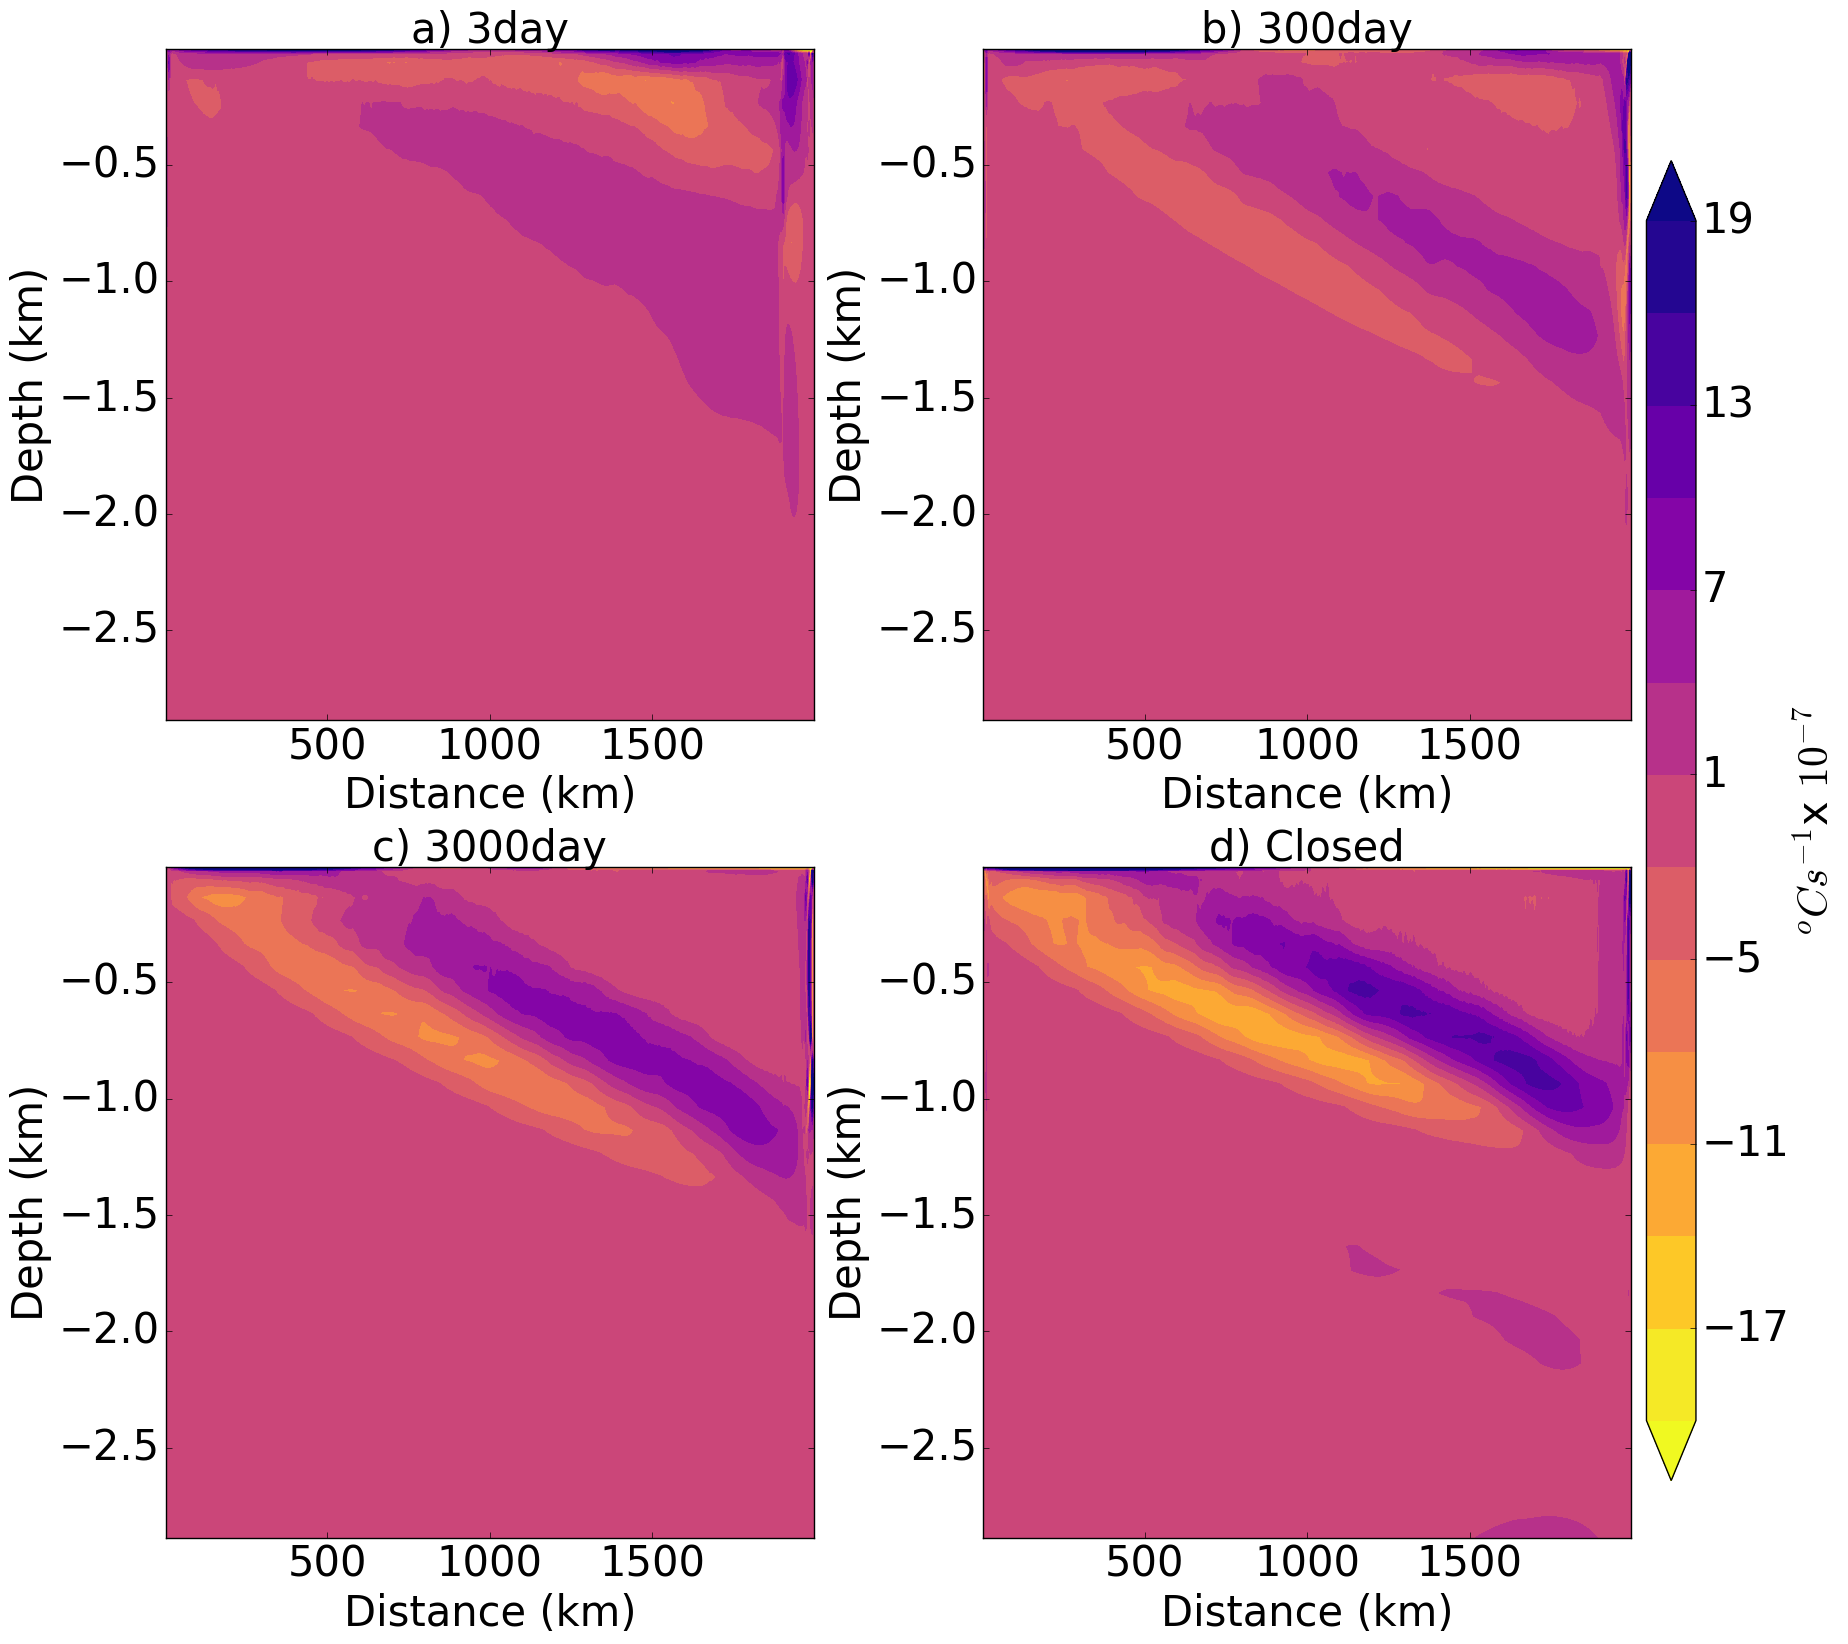

In [13]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
   

    #g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.cumsum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    #Dz = ((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).sum(axis=2) - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    #Dy = ((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).sum(axis=2) - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    dx = 5000
    nx = 200
    Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).mean(axis=2)/nx - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/dx)
    Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).mean(axis=2)/nx - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/dx)
    
    D = (Dz+Dy)/np.sum(CellVol.mean(axis=2))
 
    ax = fig.add_subplot(2, 2, i+1)
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**7, np.arange(-1,1,0.15)*20, cmap=plt.cm.plasma_r, extend='both')

    
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-7}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: invalid value encountered in less


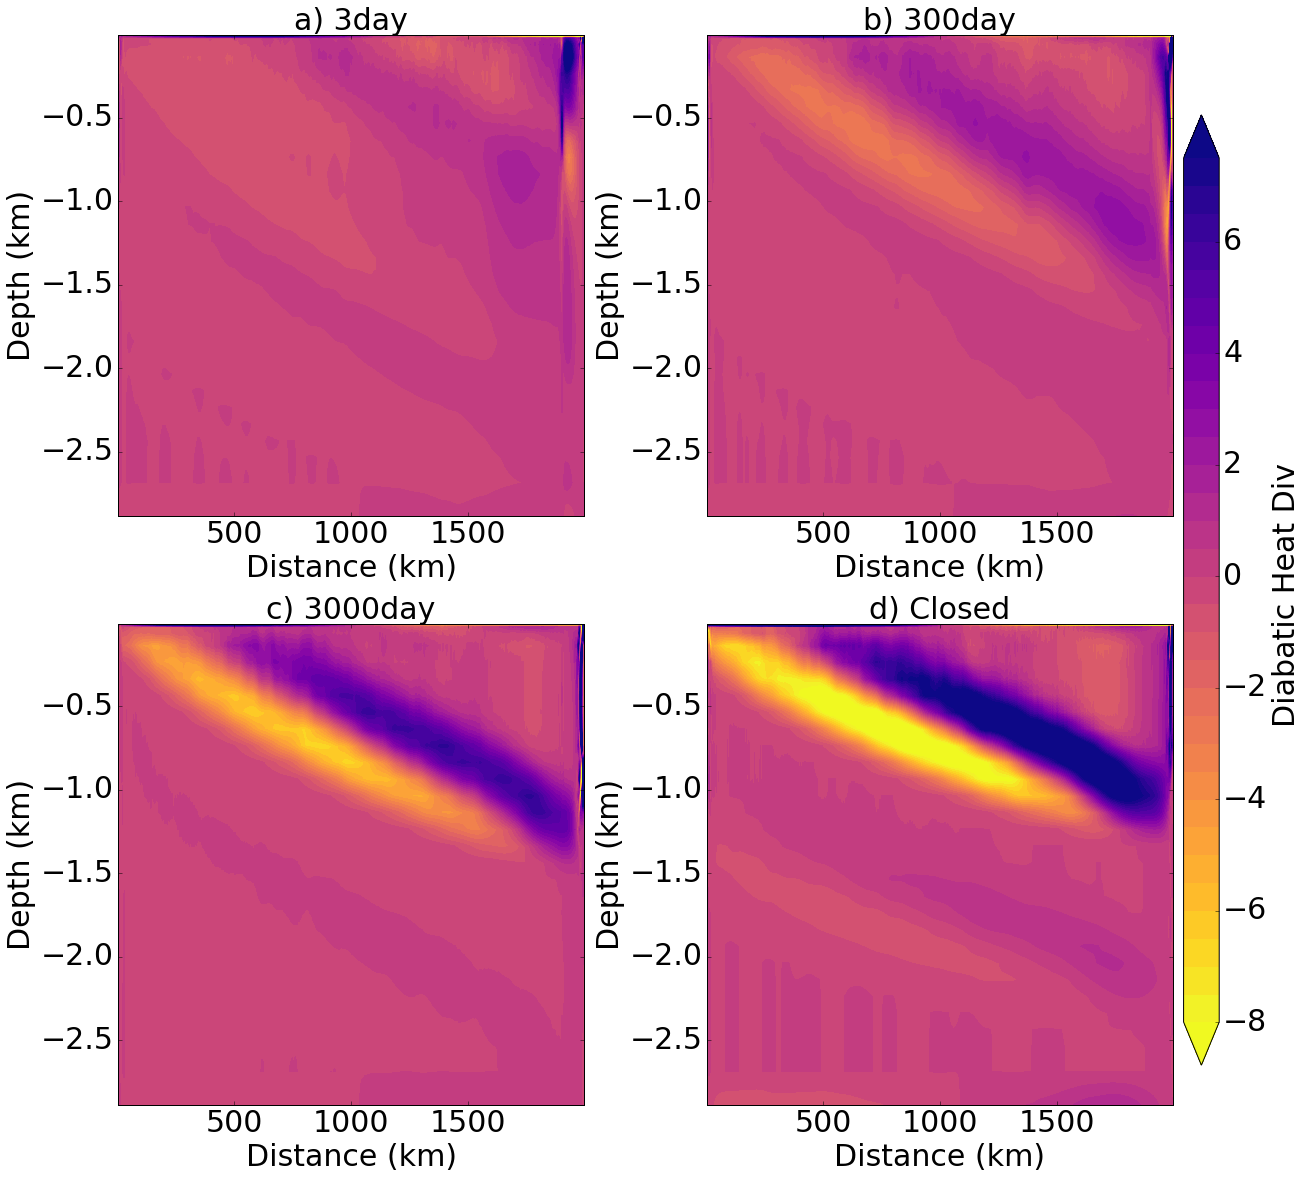

In [230]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    T = c.mnc('Tav.nc','THETA')
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:]*CellVol - Tw[0:-1,:,:]*CellVol)
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
   

    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.cumsum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    Dz = ((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).sum(axis=2) - psiz*c.ddy_cgrid_centered(T.mean(axis=2)) 
    Dy =  - psiz*c.ddz_cgrid_centered(T.mean(axis=2)) + ((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).sum(axis=2) 
    D = (Dy+Dz)/np.sum(CellVol.mean(axis=2))
    Psipred = -(Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    D*10**6, np.arange(-8,8,0.5), cmap=plt.cm.plasma_r, extend='both')
         

    
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)

cbar.ax.set_ylabel(r'Diabatic Heat Div ', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

\begin{equation}
\frac{\partial \Psi _{res} }{\partial z} \frac{\partial \overline{T}}{\partial y } + \frac{\partial \Psi _{res} }{\partial y} \frac{\partial \overline{T}}{\partial z } = \frac{\partial Q}{\partial z}+ \frac{\partial \left( \overline{w'T'}- \overline{\Psi}  T_y \right)}{\partial z }.
\end{equation}

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in less


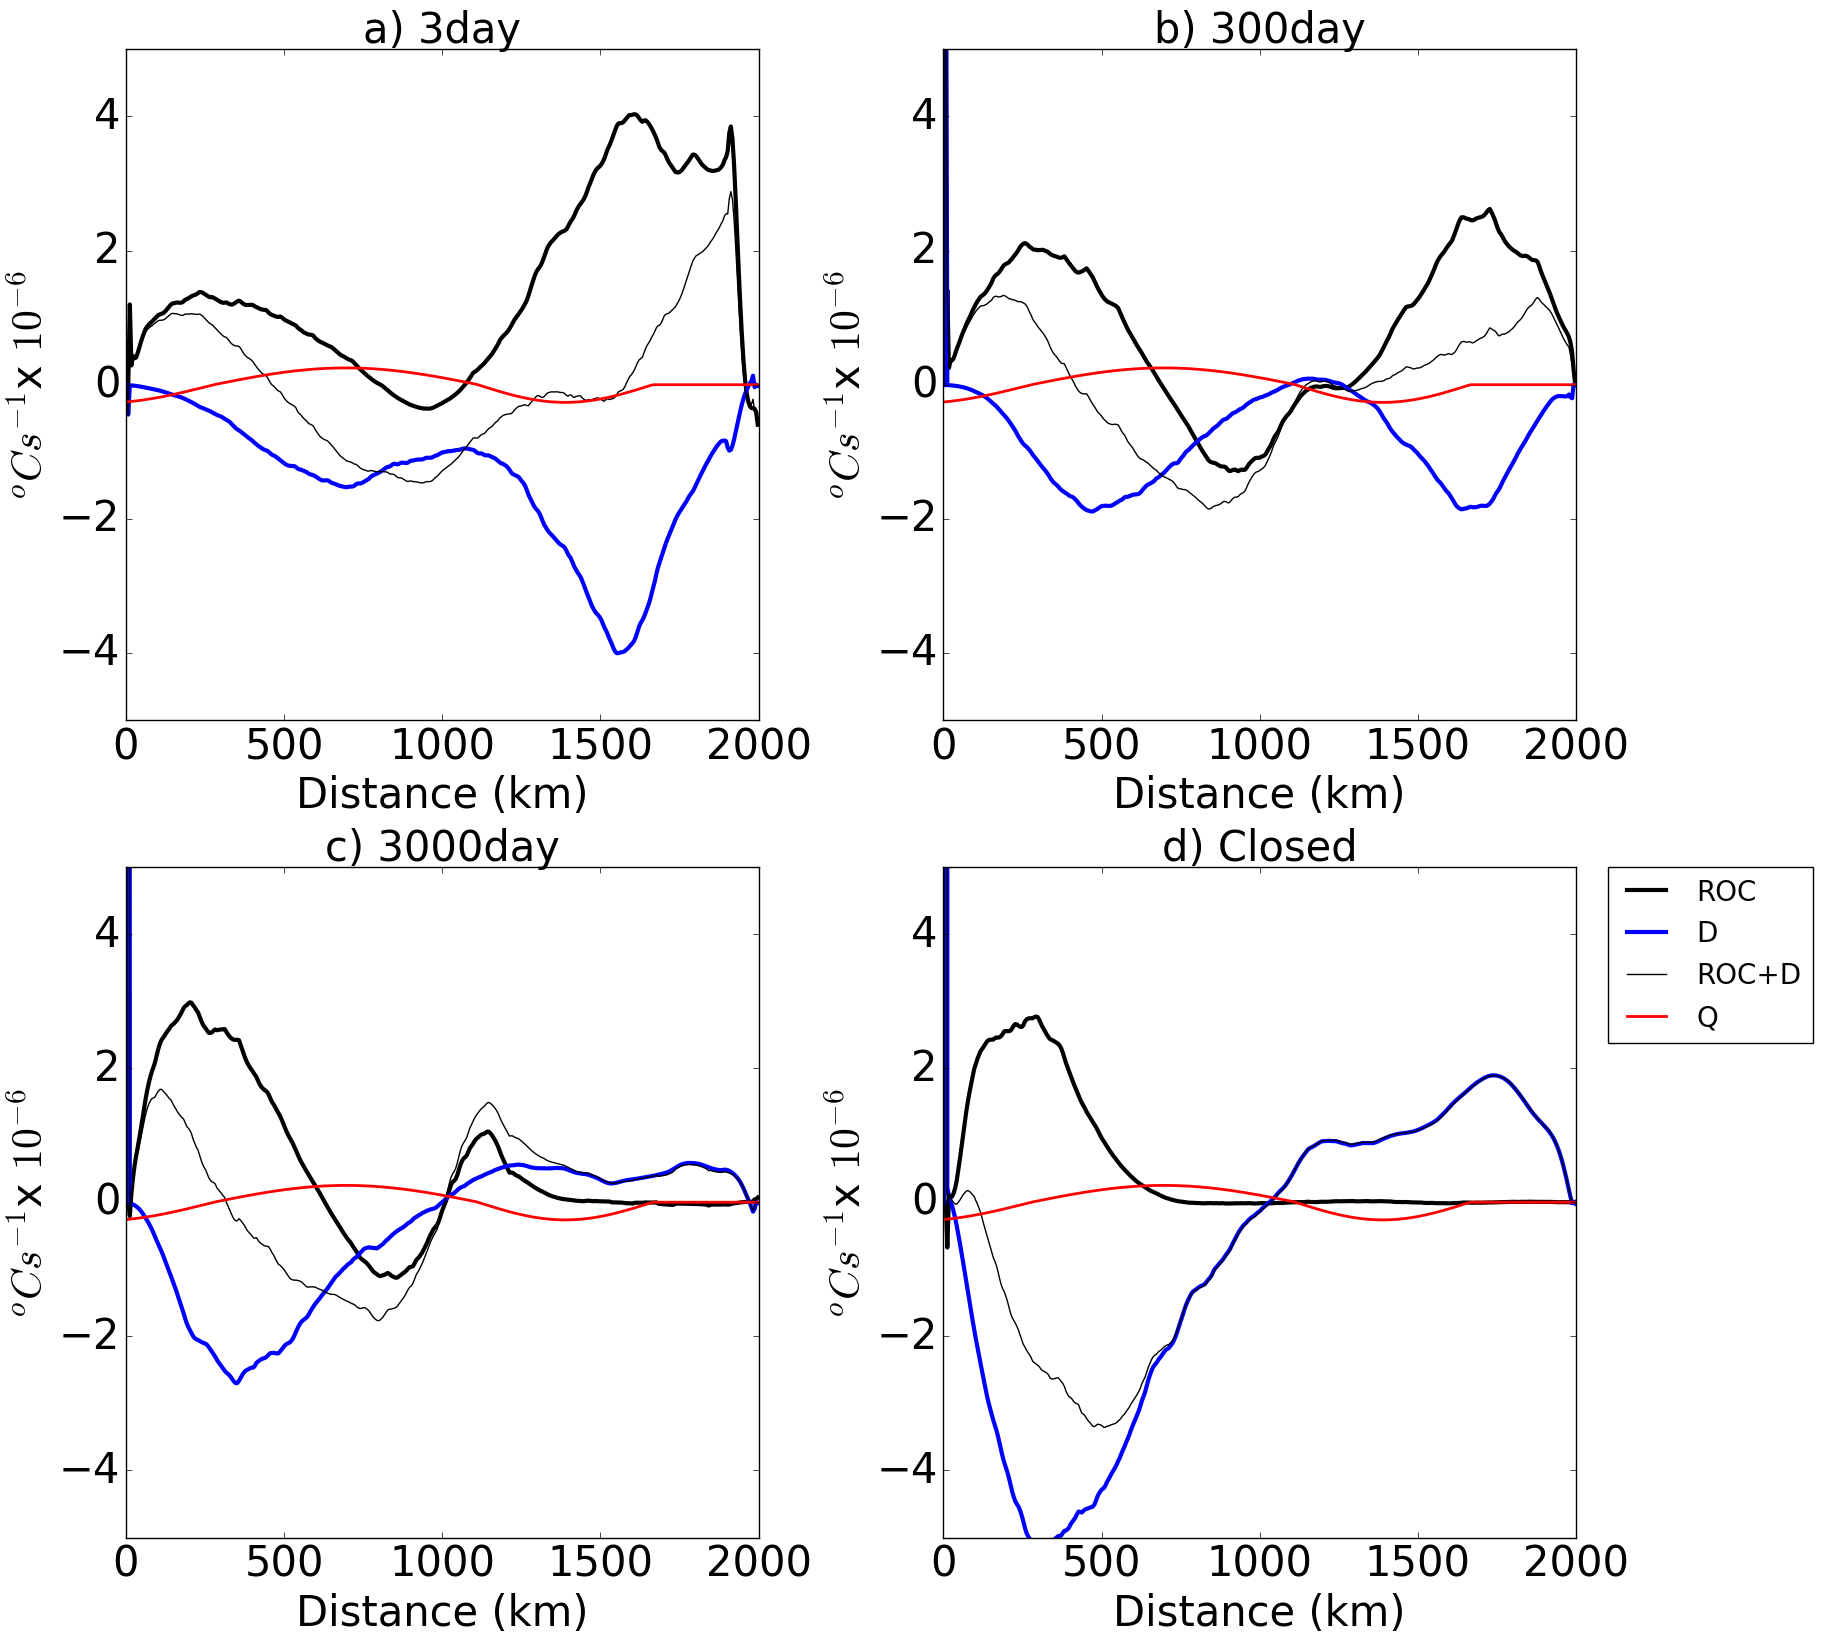

In [214]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    T = c.mnc('Tav.nc','THETA')
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1,0 ), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-4]=10**-4
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 


    #g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    psibar = (c.get_psi_bar()/c.Lx)*utils.cgrid_to_vgrid(np.mean(Tz,axis=2))
    npad = ((1,0 ), (0, 0))
    psibarw = np.pad(psibar*np.mean(utils.cgrid_to_vgrid(Ty),axis=2), pad_width=npad, mode='constant', constant_values=0)
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = -np.sum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    DEW = c.ddz_cgrid_centered(c.wgrid_to_cgrid(WT)).mean(axis=2)- c.vgrid_to_cgrid(psibar/c.Lx)*c.ddy_cgrid_centered(T.mean(axis=2))
    DEV = c.ddy_cgrid_centered(c.vgrid_to_cgrid(VT)).mean(axis=2) + c.vgrid_to_cgrid(psibar/c.Lx)*c.ddz_cgrid_centered(T.mean(axis=2))
    DE = c.ddy_cgrid_centered(DEV)+c.ddz_cgrid_centered(DEW)
    
    D = (np.nansum(DE,axis=0))/200
    
    
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)

    p = plt.plot(c.yc/1000,ROC*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

Old Cells

In [ ]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVolv = 5000**2*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # and volume weight it       
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    T = (c.mnc('Tav.nc','THETA'))
    # No slip bottom so W[-1]=0
    npad = ((0, 1), (0, 0), (0, 0))
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Isotherm slope
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Ty = c.ddy_cgrid_centered(T)
    Tz = c.ddz_cgrid_centered(T)
    Sp = Ty/Tz
    Sp[abs(Sp)<10**-6]=10**-6
    Sp[isinf(Sp)]=10**-6
    Sp[isnan(Sp)]=10**-6
    Spy = utils.cgrid_to_vgrid(Sp)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    dVTm = c.ddy_cgrid_centered(c.vgrid_to_cgrid(VTbar))
    dWTm = c.ddz_cgrid_centered(c.wgrid_to_cgrid(WTbar))
    dVTe = c.ddy_cgrid_centered(c.vgrid_to_cgrid(VpTp))
    dWTe = c.ddz_cgrid_centered(c.wgrid_to_cgrid(WpTp))
    ade = (Sp*c.vgrid_to_cgrid(VpTp))
    dVTeSp = c.ddz_cgrid_centered(ade)
    Div = -((((dVTm + dWTm+dVTe + dWTe)*CellVol/5000).sum(axis=2)).sum(axis=0))/(c.Lx)
    ROC = ((((dVTm+dWTm+dVTeSp+dVTe )*CellVol/5000).sum(axis=2)).sum(axis=0))/(c.Lx)
    D = ((((dWTe-dVTeSp )*CellVol/5000).sum(axis=2)).sum(axis=0))/(c.Lx)
    
    #if str(tau[Runs[i]]) == 'Closed':
    #    ROC = ROC*0.6
    #    D = D*0.6
       
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'k',linewidth=3) # Divergence + free surface correction 
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3) # Divergence + free surface correctio
    p = plt.plot(c.yc/1000,(D+ROC)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(Psipred)*10**6,'r',linewidth=2)
    plt.ylim(-20,20)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'ROC','D','ROC+D','Q',
              'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

plt.tight_layout()